# Importing Modules

In [3]:
# Cleanning
import pandas as pd
import numpy as np
from scipy.stats import mode

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modelling
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import iqr
from scipy.stats import scoreatpercentile as pct
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import probplot
from math import radians, cos, sin, asin, sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
import xgboost


 # Units

In [4]:
sqft_to_sqm = (0.3048)**2

# Functions

## Data Cleaning Pipeline Functions

### Importing Data

In [5]:
def load_data(file):

    path = "Data/" + file

    file1 = pd.read_excel(path)

    return file1

### Standardizing Headings

In [6]:
def standard_headings(df):
    """
    Returns a Pandas Dataframe with an standarized heading, i.e lower case and " " replaced by "_"
    
    Parameters
    ----------
    columns_list : Pandas Dataframe

    Returns
    -------
    Returns a Pandas Dataframe with an standarized heading, i.e lower case and " " replaced by "_"

    """  
    heading = df.columns
    df.columns = [clabel.lower().replace(" ", "_") for clabel in heading]
    return df


### Transform yr_built into age

In [7]:
def transform_age(df):

    df["yr_built"] = max(df["yr_built"]) - df["yr_built"]
    df = df.rename(columns={"yr_built":"age"})

    return df

### Transform yr_renovated into binary

In [8]:
def transform_renovated(df):

    df["yr_renovated"] = df["yr_renovated"].where(df["yr_renovated"] == 0, other=1)
    df = df.rename(columns={"yr_renovated":"renovated"})

    return df

### Converting to Categorical Type

In [9]:
def obj_to_cat(df, columns_list):

    for column in columns_list:

        df[column] = df[column].astype("category")

    return df

### Removing specific rows

In [10]:
def remove_rows(df):

    df = df[df["bedrooms"] != 33]

    return df

## Data Transformation

### X/y split | Train/test split | Numerical Variables Scaling

In [11]:
def my_transformations(df, test_size=0.2, scaler = "standard"):

    # x-y split

    X = df.drop("price", axis=1)
    y = df["price"]

    # Train/Test Split
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size= test_size, random_state=0)
    
    
    # Numerical and categorical variables

    X_train_num = X_train._get_numeric_data()
    X_test_num = X_test._get_numeric_data()
    X_train_cat = X_train.select_dtypes("category")
    X_test_cat = X_test.select_dtypes("category")

    # Numerical Variables Scaling
    
    if scaler == "minmax":
    
        scaler = MinMaxScaler()

    elif scaler == "standard":

        scaler = StandardScaler()
    
    scaler.fit(X_train_num)
    X_train_num_scaled = pd.DataFrame(scaler.transform(X_train_num), columns=X_train_num.columns).reset_index(drop=True)
    X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns).reset_index(drop=True)
    
    return {"train":[X_train_num_scaled, X_train_cat, y_train], "test":[X_test_num_scaled, X_test_cat, y_test]}

### Normalization

In [78]:
def var_normalization(df):    

    transformer = PowerTransformer(method="box-cox").fit(df.to_numpy().reshape(-1,1))
    power_norm = transformer.transform(df.to_numpy().reshape(-1,1))
    power_norm = pd.DataFrame(power_norm)[0]

    return (transformer, power_norm)

## Regression Functions

### Predict, generate metrics and plot

In [136]:

def prediction_plot(model, X, y, set="test"):

    # Predict
    y_pred = model.predict(X)
    result = pd.DataFrame({f"y_{set}":y, "y_pred":y_pred})

    # Metrics
    
    R2 = r2_score(y, y_pred)
    RMSE = mse(y, y_pred, squared=False)
    R2_adj = R2_adjusted(X, y, y_pred, R2)
    metrics = {"MSE":mse(y, y_pred), "RMSE":RMSE, "MAE":mae(y, y_pred), "R2":R2, "R2_adj":R2_adj}

    print(f"The model performance for the {set} set")
    print("-------------------------------------------")
    print(f"RMSE of {set} set is {RMSE}")
    print(f"Adjusted R2 score of {set} set is {R2_adj}")

    # Plots

    fig, axs = plt.subplots(1,3,figsize=(30,10))

    sns.regplot(x=f"y_{set}", y="y_pred", data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=axs[0])
    sns.histplot(y-y_pred, kde=True, ax=axs[1])
    axs[2].plot(y_pred,y - y_pred,"o")
    axs[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

    axs[0].set_title(f"y_{set}".capitalize() + " Set - Observed VS Predicted")
    axs[1].set_title(f"y_{set}".capitalize() + " Set - Histogram of the Residuals")
    axs[1].set_xlabel(f"y_{set}" + " - y_pred")
    axs[2].set_xlabel("Predicted")
    axs[2].set_ylabel("Residuals")
    axs[2].set_title("Residuals by Predicted")

    return {"Result":result, "Metrics":metrics, "Figure": (fig, axs)}


### Linear Regression

In [ ]:


def my_linear_regression(X_train, y_train, X_test, y_test):

    # Model Fit
    model = LinearRegression()
    model.fit(X_train, y_train)
    coefficients = list(model.coef_)

    # Evaluation on the Train Set
    train = prediction_plot(model, X_train, y_train, set="train")

    print()

    # Evaluation on the Test Set
    test = prediction_plot(model, X_test, y_test, set="test")

    return {"Fitting Coefficients":coefficients, "Train":train, "Test":test}




# def my_linear_regression(X_train, y_train, X_test, y_test):

#     # Model Fit
#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     coefficients = list(model.coef_)

#     # Predict
#     y_pred = model.predict(X_test)
#     result = pd.DataFrame({"y_test":y_test, "y_pred":y_pred})

#     # Metrics
    
#     R2 = r2_score(y_test, y_pred)
#     metrics = {"MSE":mse(y_test, y_pred), "RMSE":mse(y_test, y_pred, squared=False), "MAE":mae(y_test, y_pred), "R2":R2, "R2_adj":R2_adjusted(X_test, y_test, y_pred, R2)}

#     # Plots

#     fig, axs = plt.subplots(1,3,figsize=(30,10))

#     sns.regplot(x="y_test", y="y_pred", data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=axs[0])
#     sns.histplot(y_test-y_pred, kde=True, ax=axs[1])
#     axs[2].plot(y_pred,y_test - y_pred,"o")
#     axs[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

#     axs[0].set_title("Test Set - Observed VS Predicted")
#     axs[1].set_title("Test Set - Histogram of the Residuals")
#     axs[1].set_xlabel("y_test - y_pred")
#     axs[2].set_xlabel("predited")
#     axs[2].set_ylabel("residuals")
#     axs[2].set_title("Residuals by Predicted")
    


#     # Output
    
#     return {"Fitting Coefficients":coefficients, "Result":result, "Metrics":metrics, "Figure": (fig, axs)}

### Flexible Method Regression

In [130]:
def my_flex_regression(X_train, y_train, X_test, y_test, model, **kwargs):

    # Model Fit
    model.set_params(**kwargs)
    model.fit(X_train, y_train)
    coefficients = list(model.coef_)

    # Evaluation on the Train Set
    train = prediction_plot(model, X_train, y_train, set="train")

    print()

    # Evaluation on the Test Set
    test = prediction_plot(model, X_test, y_test, set="test")

    return {"Fitting Coefficients":coefficients, "Train":train, "Test":test}

## Plotting

In [14]:
def my_correlation_heatmap(df, figsize = (16,16)): 

    # correlation matrix

    correlation_matrix = df.corr()

    # create figure and axes
    fig, ax = plt.subplots(figsize = figsize)

    # set title
    ax.set_title('Correlation Heatmap', fontweight='bold')


    sns.heatmap(correlation_matrix,  # the data for the heatmap
                annot=True,  # show the actual values of correlation
                cmap='seismic',  # provide the 'seismic' colormap
                center=0,  # specify the value at which to center the colormap
                )

## Utility Functions

In [15]:
# Function to store in dictionary the number of nan values per column

def nan_counter(df):
    
    """
    Returns a dictionary containing the number of nan values per column (for dataframe df)

    Parameters
    ----------
    df : Pandas dataframe

    Returns
    -------
    remaining_nan : Dictionary
        Contains the number of nan values in each column of the dataframe

    """
    
    remaining_nan = {}

    for column in df.columns:

        remaining_nan[column] = df[column][df[column].isna() == True].size

    return remaining_nan

In [16]:
def R2_adjusted(X, y, y_pred, R2=None):
    
    if R2==None:
    
        R2 = r2_score(y, y_pred)
    
    else:
        R2_adj = 1 - (1-R2)*(len(y)-1)/(len(y)-X.shape[1]-1)

    return R2_adj

In [17]:
# from haversine import haversine, Unit
# https://pypi.org/project/haversine/


def haversine(list_long_lat, other=[-122.336283, 47.609395]):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees), in this case the 2nd point is in the 
    Pike Pine Retail Core of Seattle, WA.
    """
    lon1, lat1 = list_long_lat[0], list_long_lat[1]
    lon2, lat2 = other[0], other[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

# Pipeline Controller

In [18]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition"]
# bucket_columns = ["st", "gender"]
# clean_columns_NaN = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
# clean_columns_zeros = ["income"]
# clean_columns_cat = [("gender", "U")]
# int_columns = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
cat_columns = ['waterfront', 'view', 'grade', 'renovated']

# bucketing_dict = {"F":"F", "female":"F", "Femal":"F"
#                  ,"M":"M", "Male":"M"
#                  ,"California": "California", "Cali": "California"
#                  ,"Arizona":"Arizona","AZ":"Arizona"
#                  ,"Washington":"Washington", "WA":"Washington"
#                  ,"Oregon":"Oregon"
#                  ,"Nevada":"Nevada"
#                  ,np.nan:np.nan
#                  }

In [19]:
hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_age)
.pipe(transform_renovated)
# .pipe(dt_corrector)
# .pipe(bucket_series, bucket_columns, bucketing_dict)
# .drop_duplicates().reset_index(drop=True)
# .pipe(replace_by, clean_columns_NaN)
# .pipe(replace_by, clean_columns_zeros)
# .pipe(replace_by_cat, clean_columns_cat)
# .dropna()
# .pipe(standardize_data)
# .pipe(float_to_int, float_columns)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [20]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,renovated,zipcode,lat,long,sqft_living15,price
0,3,1.00,1180,1.0,0,0,7,60,0,98178,47.5112,-122.257,1340,221900
1,3,2.25,2570,2.0,0,0,7,64,1,98125,47.7210,-122.319,1690,538000
2,2,1.00,770,1.0,0,0,6,82,0,98028,47.7379,-122.233,2720,180000
3,4,3.00,1960,1.0,0,0,7,50,0,98136,47.5208,-122.393,1360,604000
4,3,2.00,1680,1.0,0,0,8,28,0,98074,47.6168,-122.045,1800,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0,0,8,6,0,98103,47.6993,-122.346,1530,360000
21593,4,2.50,2310,2.0,0,0,8,1,0,98146,47.5107,-122.362,1830,400000
21594,2,0.75,1020,2.0,0,0,7,6,0,98144,47.5944,-122.299,1020,402101
21595,3,2.50,1600,2.0,0,0,8,11,0,98027,47.5345,-122.069,1410,400000


# Initial Data Exploration

In [19]:
hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
)

In [20]:
hp_df

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,360000
21593,6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,400000
21594,1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,402101
21595,291310100,2015-01-16,3,2.50,1600,2388,2.0,0,0,3,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,400000


In [21]:
hp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

In [22]:
hp_df.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,5.402966e+05
std,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950,3.673681e+05
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3.220000e+05
50%,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


In [23]:
hp_df_shape = hp_df.shape
hp_df_shape

(21597, 21)

In [24]:
nan_counter(hp_df)

{'id': 0,
 'date': 0,
 'bedrooms': 0,
 'bathrooms': 0,
 'sqft_living': 0,
 'sqft_lot': 0,
 'floors': 0,
 'waterfront': 0,
 'view': 0,
 'condition': 0,
 'grade': 0,
 'sqft_above': 0,
 'sqft_basement': 0,
 'yr_built': 0,
 'yr_renovated': 0,
 'zipcode': 0,
 'lat': 0,
 'long': 0,
 'sqft_living15': 0,
 'sqft_lot15': 0,
 'price': 0}

In [25]:
hp_df.drop_duplicates().shape

(21597, 21)

In [26]:
dep_var = hp_df["price"]

## Price Analysis

### Description and Distribution

In [27]:
# Descriptive statistics summary
dep_var.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

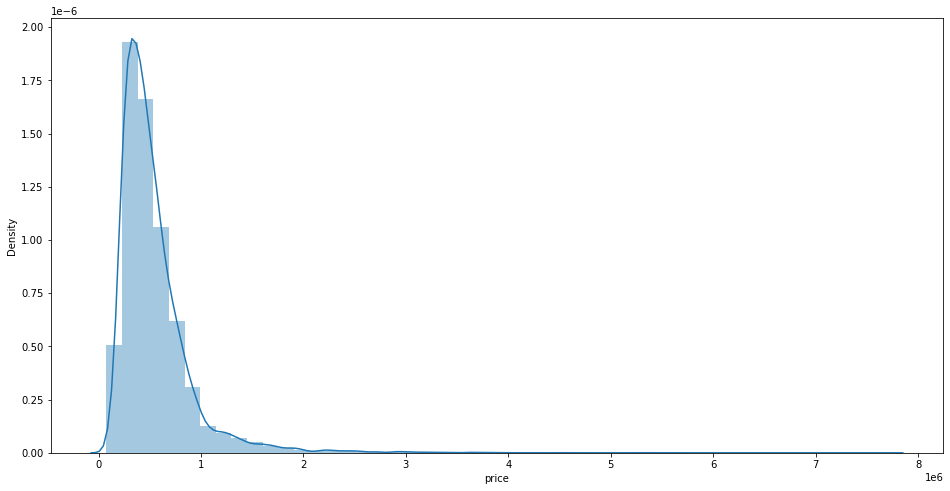

In [28]:
# Histogram

# create figure and axes
fig, ax = plt.subplots(figsize = (16,8))

sns.distplot(dep_var)

In [29]:
# Skewness and Kurtosis
print(f"Skewness: {dep_var.skew()}")
print(f"Kurtosis: {dep_var.kurt()}")

Skewness: 4.023364652271239
Kurtosis: 34.54135857673376


C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

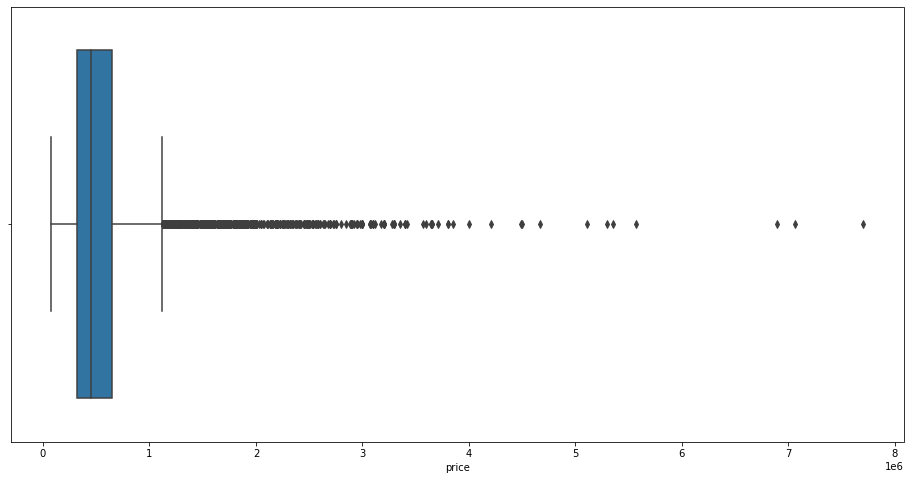

In [30]:
# Boxplot

# create figure and axes
fig, ax = plt.subplots(figsize = (16,8))

sns.boxplot(dep_var)

### Feature Correlations with Price

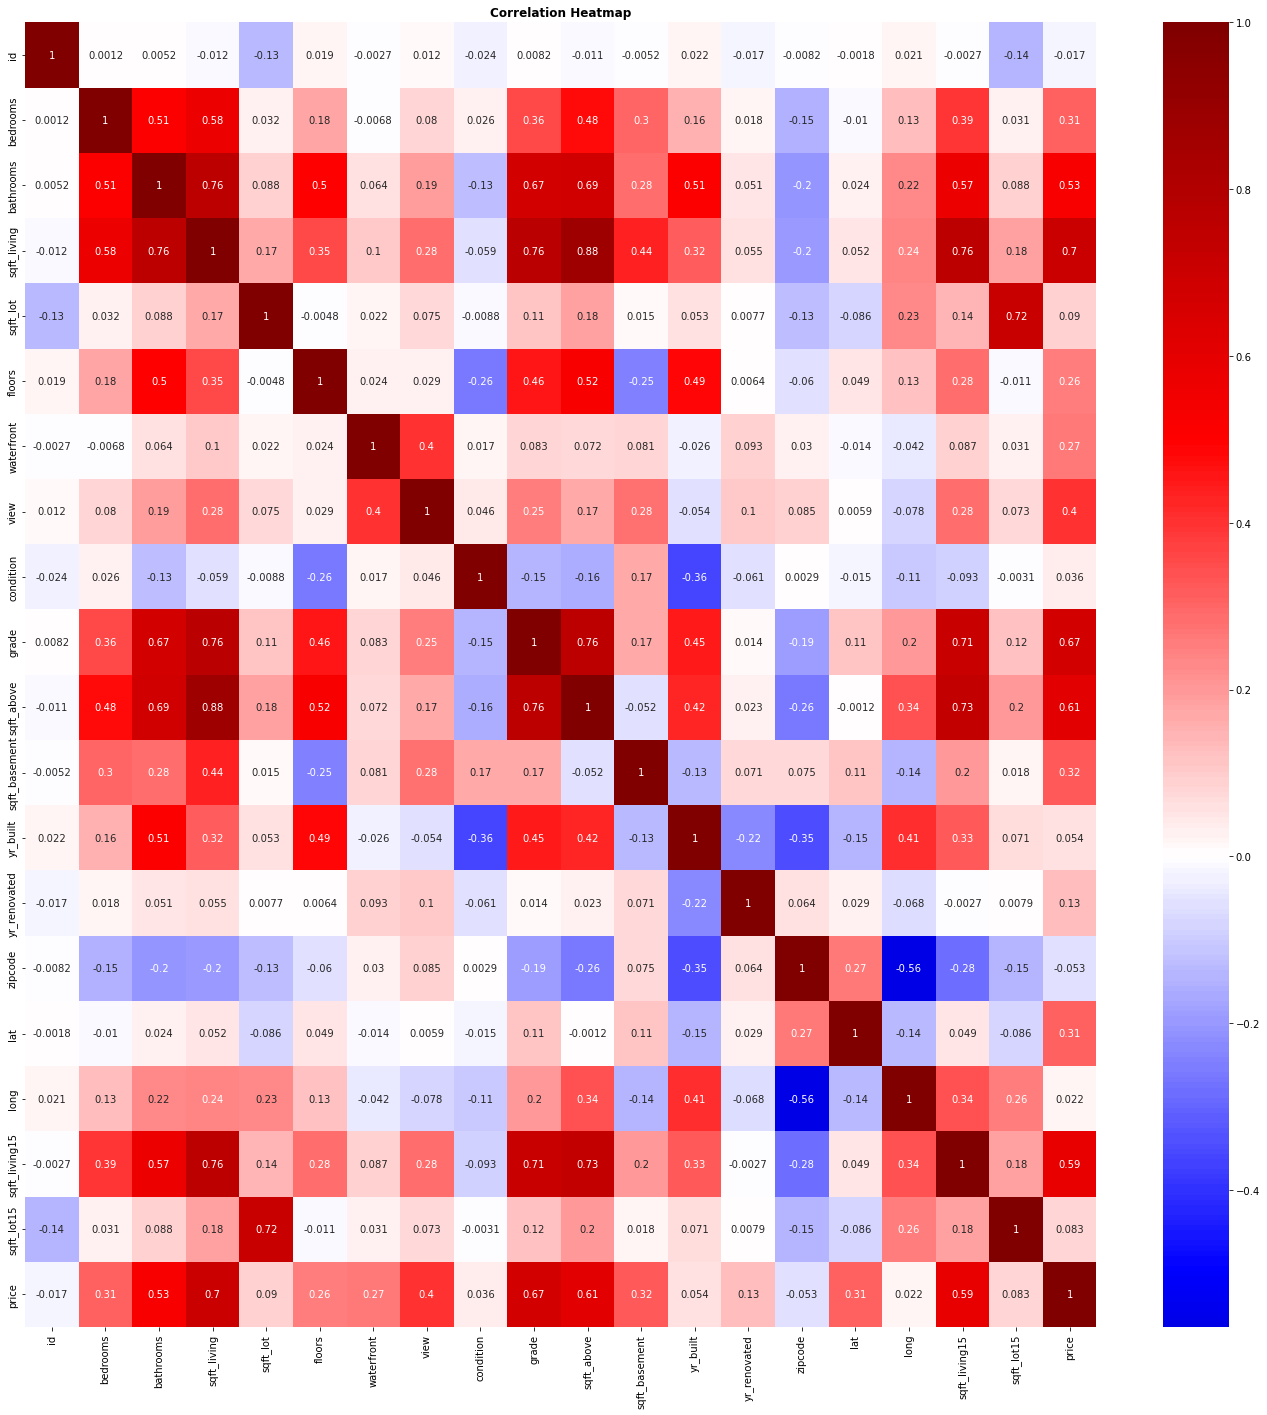

In [31]:
my_correlation_heatmap(hp_df, figsize=(24,24))

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

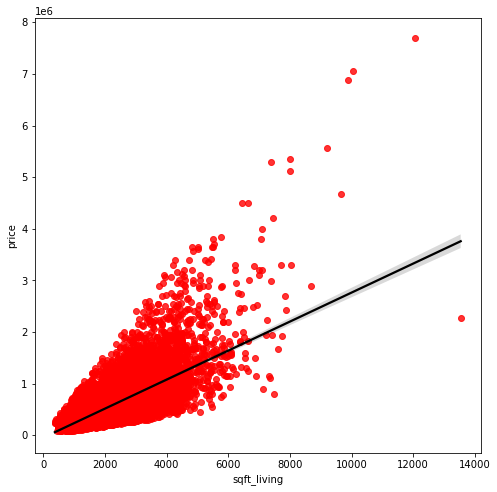

In [33]:
# Scatter plot with sqft_living
var = 'sqft_living'
data = pd.concat([dep_var, hp_df[var]], axis=1)

fig, ax = plt.subplots(figsize = (8,8))
sns.regplot(x=var, y="price", data=data, scatter_kws={"color": "red"}, line_kws={"color": "black"})


<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

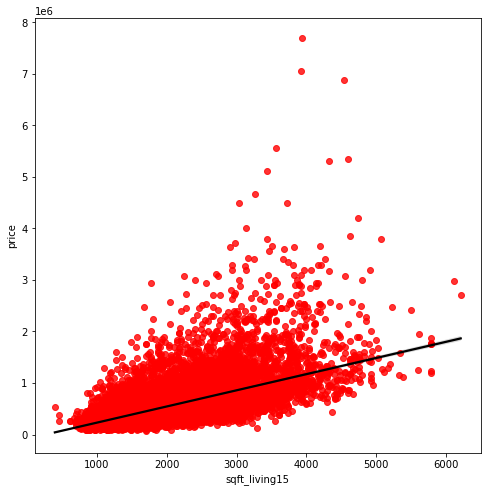

In [34]:
# Scatter plot with sqft_living15
var = 'sqft_living15'
data = pd.concat([dep_var, hp_df[var]], axis=1)

fig, ax = plt.subplots(figsize = (8,8))
sns.regplot(x=var, y="price", data=data, scatter_kws={"color": "red"}, line_kws={"color": "black"})


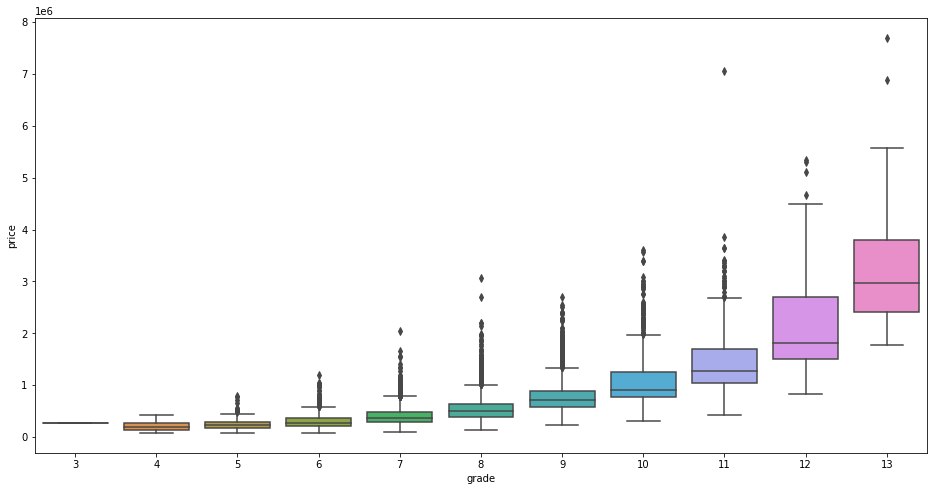

In [35]:
#box plot grade/saleprice
var = 'grade'
data = pd.concat([dep_var, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

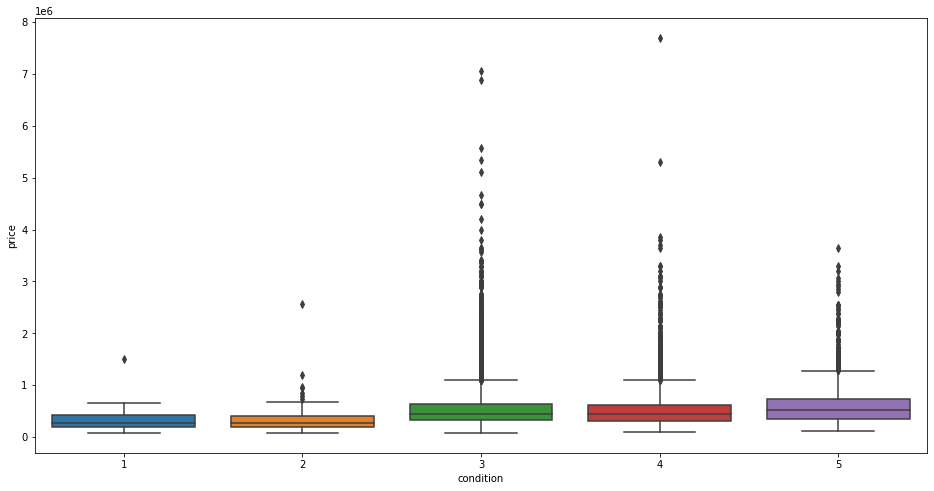

In [36]:
#box plot condition/saleprice
var = 'condition'
data = pd.concat([dep_var, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

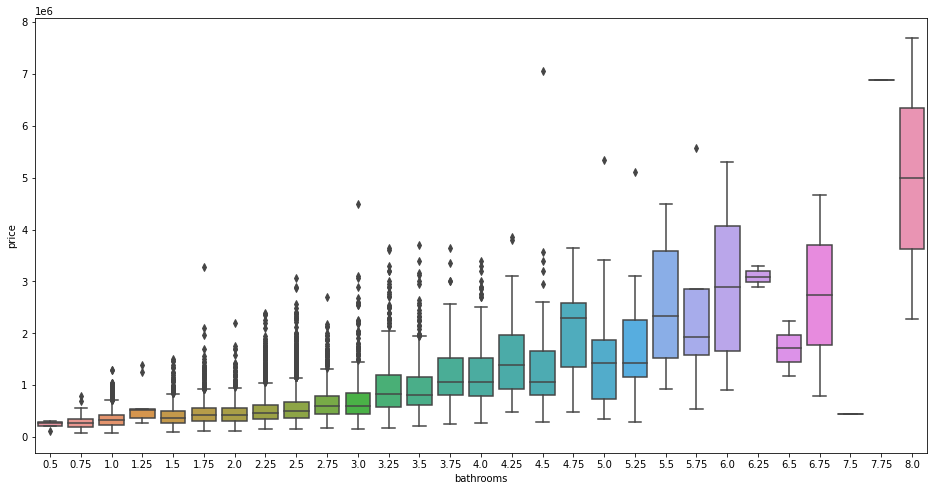

In [37]:
#box plot n bathrooms/saleprice
var = 'bathrooms'
data = pd.concat([dep_var, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

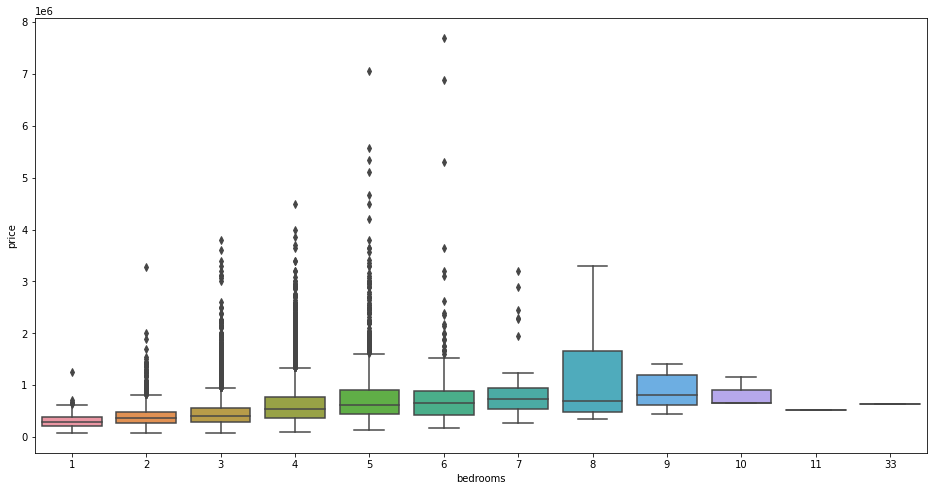

In [38]:
#box plot n bedrooms/saleprice
var = 'bedrooms'
data = pd.concat([dep_var, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

In [39]:
# Records with yr_renovated = 0

yr_renovated_n_0 = hp_df.yr_renovated.value_counts(dropna=False).sort_index()

print(f'The number of record with availabe info regarding the renovation year is {hp_df_shape[0] - yr_renovated_n_0[0]}.')


The number of record with availabe info regarding the renovation year is 914.


# Dropping Features

In [40]:
drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition"]

# id and date are useless for our analysis
# sqft_lot, sqft_above, sqft_basement and sqft_lot15 are highly correlated with sqft_living and therefore redundant
# the information contained in condition is already in grade and its correlation with price is very low. It can be dropped

In [41]:
hp_df = hp_df.drop(columns = drop_columns)

# Data Transformations

Let us tranform the construction year of the houses into a variable representing the age.

In [42]:
max(hp_df["yr_built"])

2015

In [43]:
hp_df["yr_built"] =  max(hp_df["yr_built"]) - hp_df["yr_built"]

In [44]:
hp_df = hp_df.rename(columns={"yr_built":"age"})

In [45]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,yr_renovated,zipcode,lat,long,sqft_living15,price
0,3,1.00,1180,1.0,0,0,7,60,0,98178,47.5112,-122.257,1340,221900
1,3,2.25,2570,2.0,0,0,7,64,1991,98125,47.7210,-122.319,1690,538000
2,2,1.00,770,1.0,0,0,6,82,0,98028,47.7379,-122.233,2720,180000
3,4,3.00,1960,1.0,0,0,7,50,0,98136,47.5208,-122.393,1360,604000
4,3,2.00,1680,1.0,0,0,8,28,0,98074,47.6168,-122.045,1800,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0,0,8,6,0,98103,47.6993,-122.346,1530,360000
21593,4,2.50,2310,2.0,0,0,8,1,0,98146,47.5107,-122.362,1830,400000
21594,2,0.75,1020,2.0,0,0,7,6,0,98144,47.5944,-122.299,1020,402101
21595,3,2.50,1600,2.0,0,0,8,11,0,98027,47.5345,-122.069,1410,400000


We transform also the renovation year into a binary variable representing if the house has been renovated or not.

In [46]:
hp_df["yr_renovated"] = hp_df["yr_renovated"].where(hp_df["yr_renovated"]==0, other=1)

In [47]:
hp_df["yr_renovated"].value_counts()

0    20683
1      914
Name: yr_renovated, dtype: int64

In [48]:
hp_df = hp_df.rename(columns={"yr_renovated":"renovated"})

There is one record with 33 rooms that is obviously a typo. We will remove this row.

In [49]:
hp_df = hp_df[hp_df["bedrooms"] != 33]

In [50]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,renovated,zipcode,lat,long,sqft_living15,price
0,3,1.00,1180,1.0,0,0,7,60,0,98178,47.5112,-122.257,1340,221900
1,3,2.25,2570,2.0,0,0,7,64,1,98125,47.7210,-122.319,1690,538000
2,2,1.00,770,1.0,0,0,6,82,0,98028,47.7379,-122.233,2720,180000
3,4,3.00,1960,1.0,0,0,7,50,0,98136,47.5208,-122.393,1360,604000
4,3,2.00,1680,1.0,0,0,8,28,0,98074,47.6168,-122.045,1800,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0,0,8,6,0,98103,47.6993,-122.346,1530,360000
21593,4,2.50,2310,2.0,0,0,8,1,0,98146,47.5107,-122.362,1830,400000
21594,2,0.75,1020,2.0,0,0,7,6,0,98144,47.5944,-122.299,1020,402101
21595,3,2.50,1600,2.0,0,0,8,11,0,98027,47.5345,-122.069,1410,400000


# Conversion to Category Type

In [51]:
cat_columns = ['waterfront', 'view', 'grade', 'renovated']

In [52]:
# hp_df = obj_to_cat(hp_df, columns_list=cat_columns)

# Normalization

## Price

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


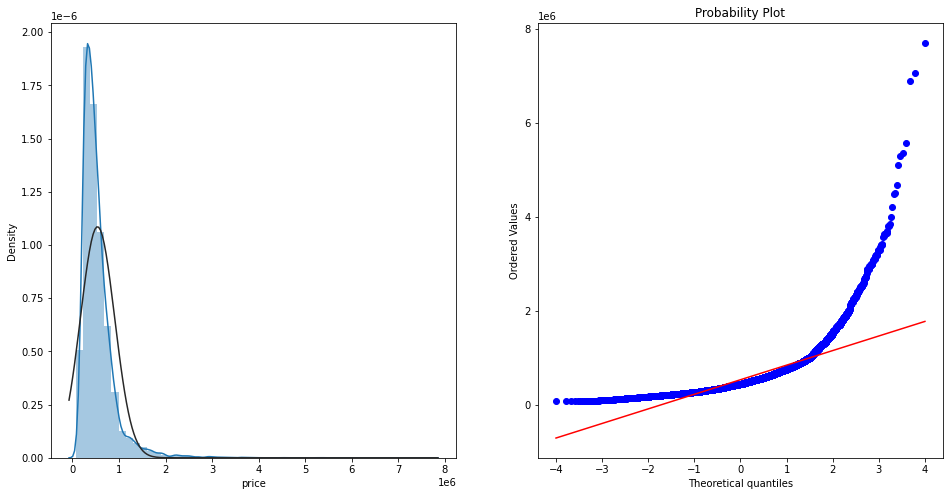

In [53]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(dep_var,fit=norm, ax=axs[0])
result = probplot(dep_var, plot=plt)

### Logarithmic Transformation

In [54]:
price_log_norm = np.log(dep_var)

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


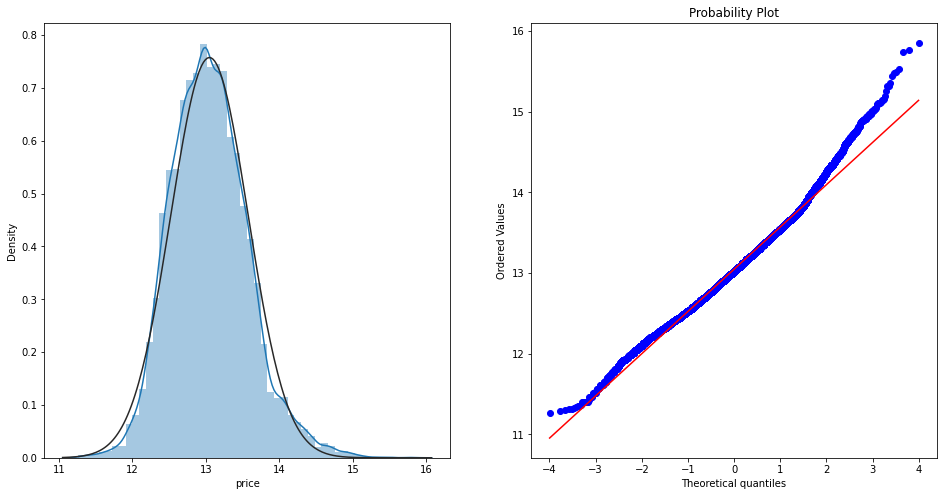

In [55]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(price_log_norm,fit=norm, ax=axs[0])
result = probplot(price_log_norm, plot=plt)

### Power Transformation

In [56]:
price_transformer = PowerTransformer(method="box-cox").fit(dep_var.to_numpy().reshape(-1,1))

price_power_norm = price_transformer.transform(dep_var.to_numpy().reshape(-1,1))
print(price_transformer.lambdas_)
price_power_norm = pd.DataFrame(price_power_norm)[0]

[-0.23611204]


C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


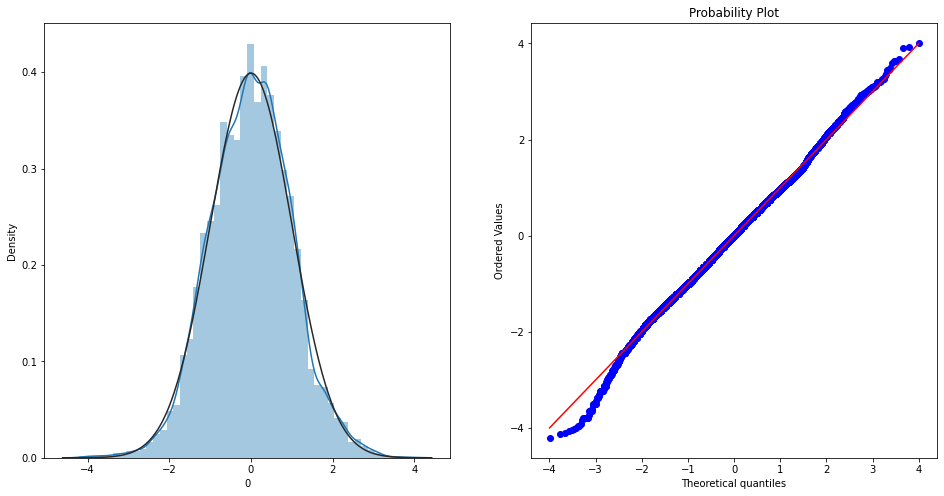

In [57]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(price_power_norm,fit=norm, ax=axs[0])
result = probplot(price_power_norm, plot=plt)

## sqft_living

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


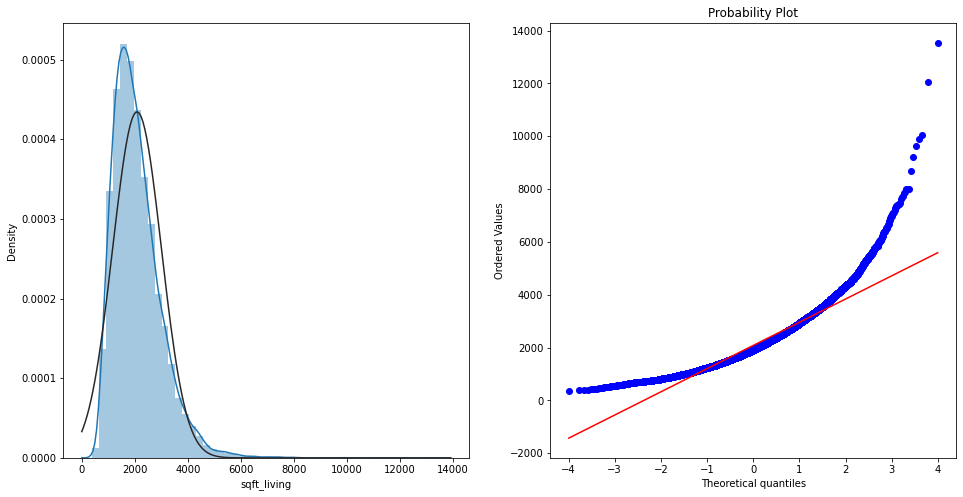

In [58]:
var = "sqft_living"

# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(hp_df[var],fit=norm, ax=axs[0])
result = probplot(hp_df[var], plot=plt)

### Logarithmic Transformation

In [59]:
sqft_living_log_norm = np.log(hp_df[var])

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


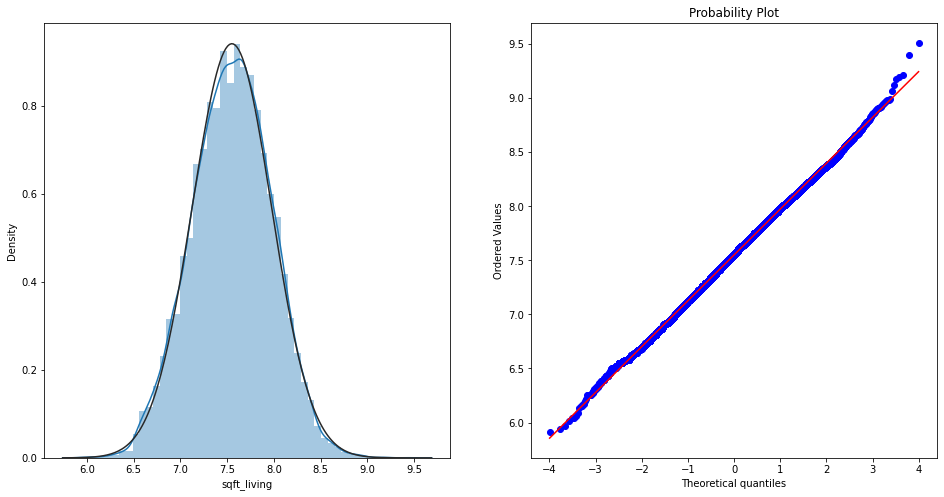

In [60]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living_log_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living_log_norm, plot=plt)

### Power Transformation

In [61]:
sqft_living_transformer = PowerTransformer(method="box-cox").fit(hp_df[var].to_numpy().reshape(-1,1))

sqft_living_power_norm = sqft_living_transformer.transform(hp_df[var].to_numpy().reshape(-1,1))
print(sqft_living_transformer.lambdas_)
sqft_living_power_norm = pd.DataFrame(sqft_living_power_norm)[0]

[0.02221622]


C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


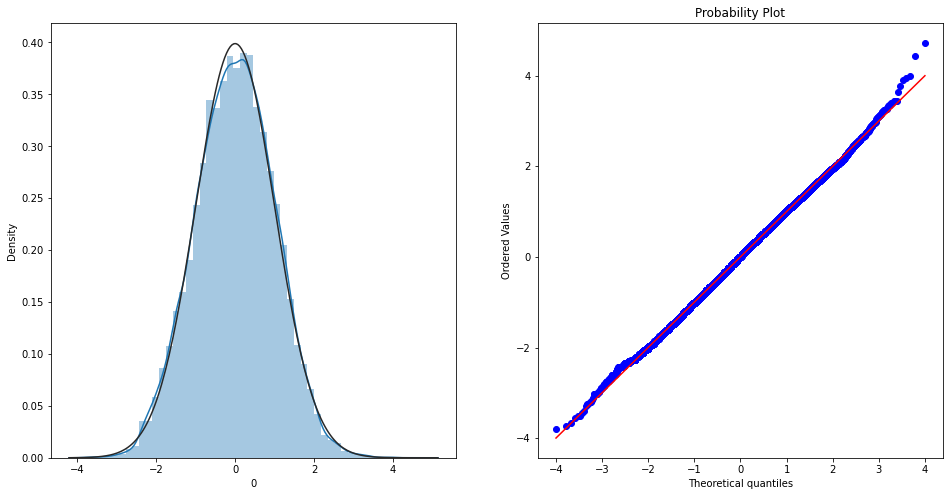

In [62]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living_power_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living_power_norm, plot=plt)

## sqft_living15

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


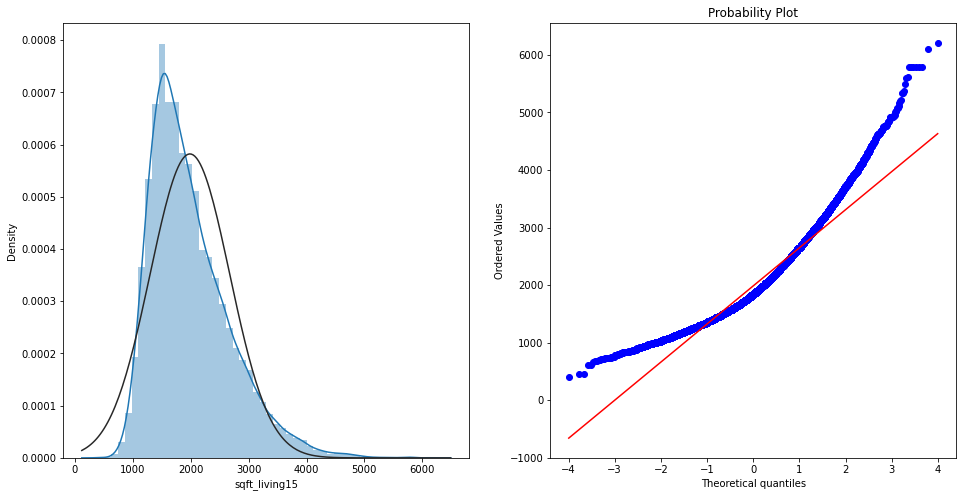

In [63]:
var = "sqft_living15"

# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(hp_df[var],fit=norm, ax=axs[0])
result = probplot(hp_df[var], plot=plt)

### Logarithmic Transformation

In [64]:
sqft_living15_log_norm = np.log(hp_df[var])

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


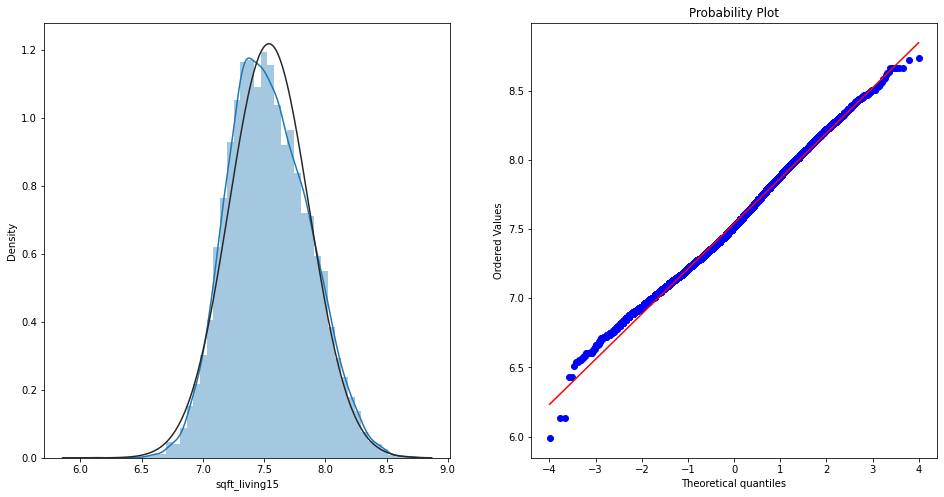

In [65]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living15_log_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living15_log_norm, plot=plt)

### Power Transformation

In [66]:
sqft_living15_transformer = PowerTransformer(method="box-cox").fit(hp_df[var].to_numpy().reshape(-1,1))

sqft_living15_power_norm = sqft_living15_transformer.transform(hp_df[var].to_numpy().reshape(-1,1))
print(sqft_living15_transformer.lambdas_)
sqft_living15_power_norm = pd.DataFrame(sqft_living15_power_norm)[0]

[-0.23134014]


C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


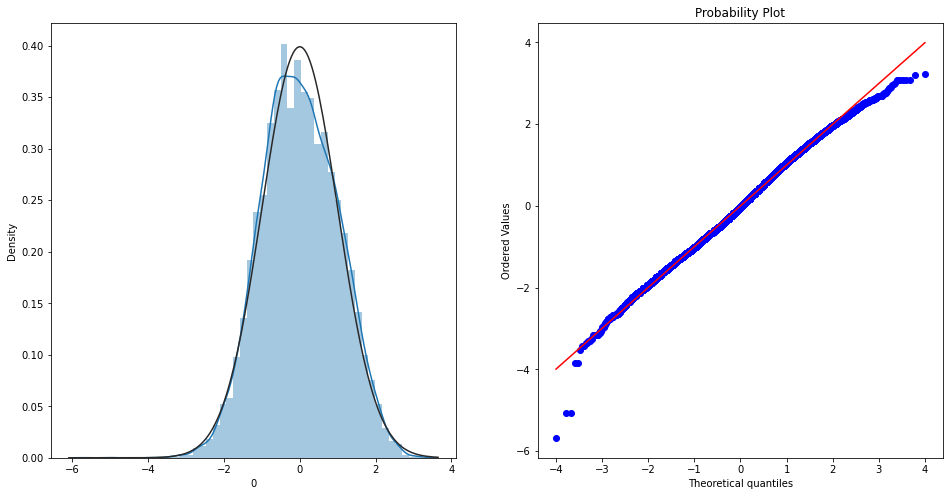

In [67]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living15_power_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living15_power_norm, plot=plt)

In [68]:
hp_df["price"] = price_power_norm
hp_df["sqft_living"] = sqft_living_log_norm
hp_df["sqft_living15"] = sqft_living15_log_norm

In [69]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,renovated,zipcode,lat,long,sqft_living15,price
0,3,1.00,7.073270,1.0,0,0,7,60,0,98178,47.5112,-122.257,7.200425,-1.489851
1,3,2.25,7.851661,2.0,0,0,7,64,1,98125,47.7210,-122.319,7.432484,0.340940
2,2,1.00,6.646391,1.0,0,0,6,82,0,98028,47.7379,-122.233,7.908387,-1.981305
3,4,3.00,7.580700,1.0,0,0,7,50,0,98136,47.5208,-122.393,7.215240,0.553099
4,3,2.00,7.426549,1.0,0,0,8,28,0,98074,47.6168,-122.045,7.495542,0.240972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,7.333023,3.0,0,0,8,6,0,98103,47.6993,-122.346,7.333023,-0.442326
21593,4,2.50,7.745003,2.0,0,0,8,1,0,98146,47.5107,-122.362,7.512071,-0.229673
21594,2,0.75,6.927558,2.0,0,0,7,6,0,98144,47.5944,-122.299,6.927558,-0.219237
21595,3,2.50,7.377759,2.0,0,0,8,11,0,98027,47.5345,-122.069,7.251345,-0.229673


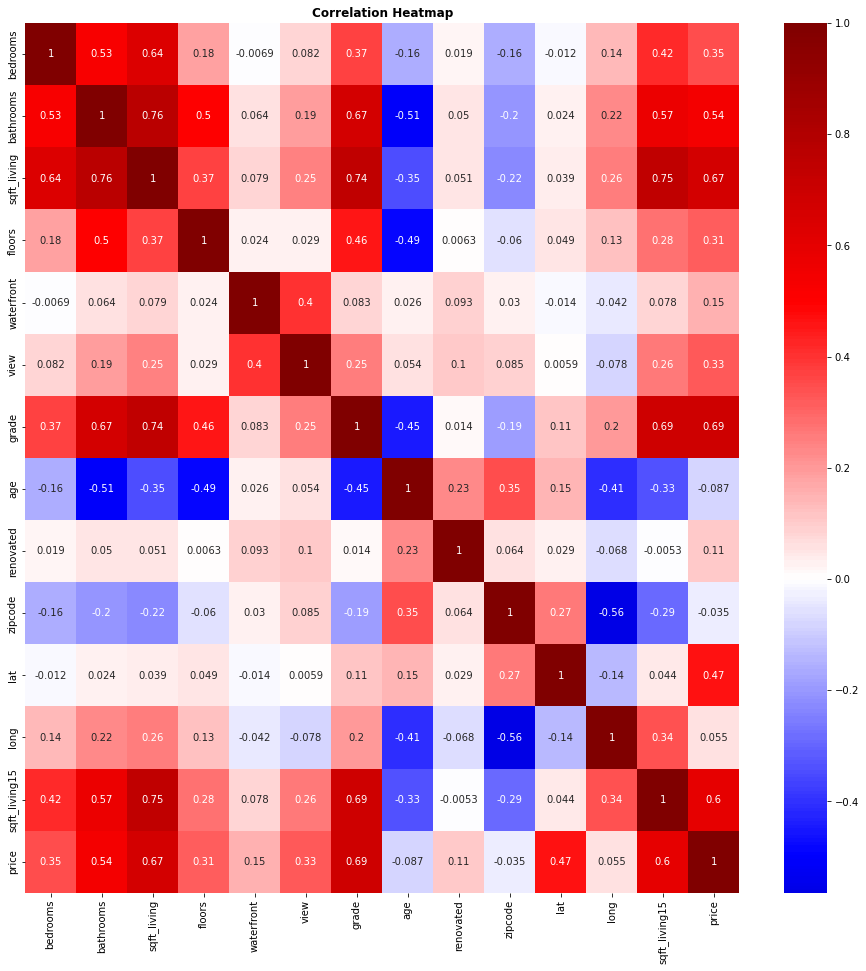

In [70]:
my_correlation_heatmap(hp_df)

# Location Variables - dist_to_

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexi

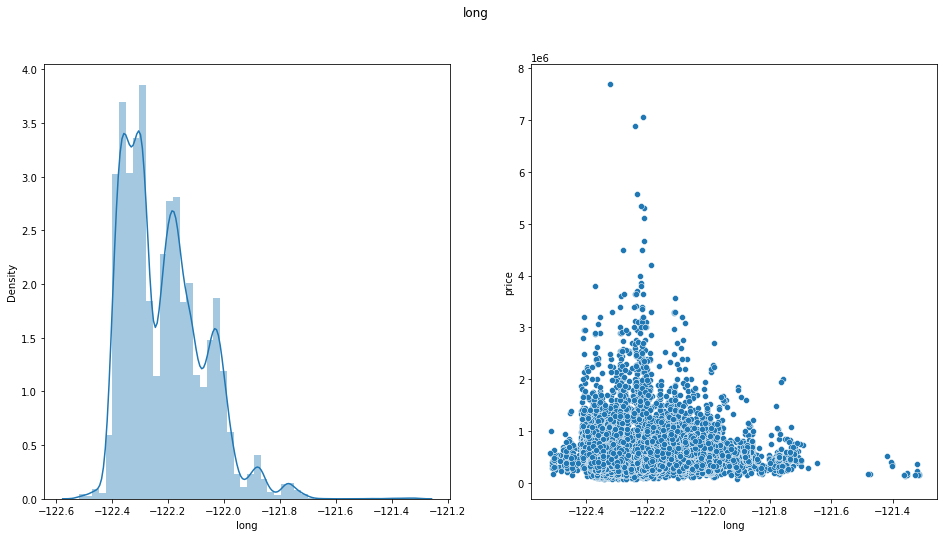

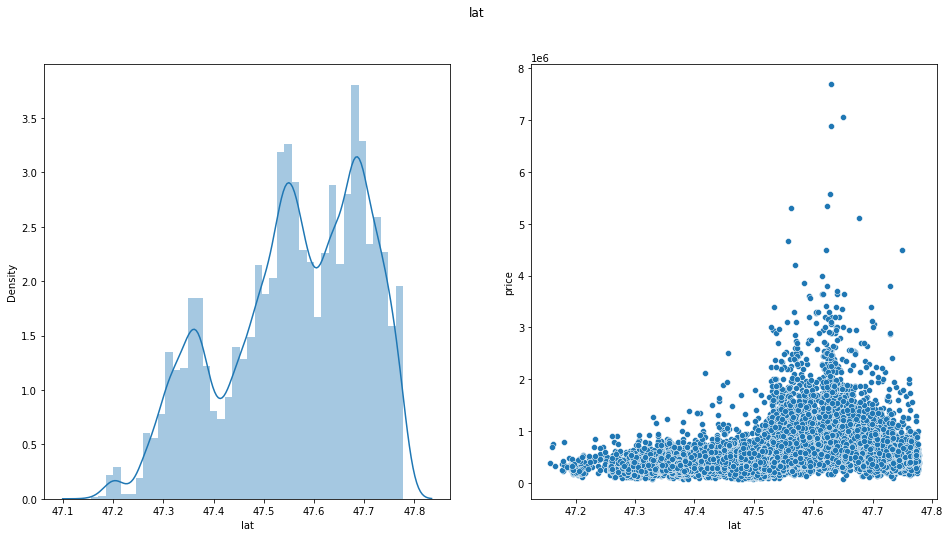

In [71]:
latlong = hp_df[['long', 'lat']]



for col in latlong:
    x = latlong[col]
    y = dep_var

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    sns.distplot(x)
    plt.subplot(1,2,2)

    sns.scatterplot(x, y)
    plt.suptitle(col)
    #plt.tight_layout
    #plt.savefig(col + '.png')

In [72]:
latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))

C:\Users\ehern\AppData\Local\Temp/ipykernel_25476/1817949222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))


In [73]:
latlong["long_lat"]

0        (-122.257, 47.5112)
1         (-122.319, 47.721)
2        (-122.233, 47.7379)
3        (-122.393, 47.5208)
4        (-122.045, 47.6168)
                ...         
21592    (-122.346, 47.6993)
21593    (-122.362, 47.5107)
21594    (-122.299, 47.5944)
21595    (-122.069, 47.5345)
21596    (-122.299, 47.5941)
Name: long_lat, Length: 21596, dtype: object

In [ ]:

hp_df['dist_to_seattle'] = latlong['long_lat'].apply(haversine)

hp_df['dist_to_bellevue'] = latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492])

# hp_df['dist_to_medina'] = latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492])

In [75]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,renovated,zipcode,lat,long,sqft_living15,price,dist_to_seattle,dist_to_bellevue
0,3,1.00,7.073270,1.0,0,0,7,60,0,98178,47.5112,-122.257,7.200425,-1.489851,12.434278,12.771789
1,3,2.25,7.851661,2.0,0,0,7,64,1,98125,47.7210,-122.319,7.432484,0.340940,12.477217,15.159928
2,2,1.00,6.646391,1.0,0,0,6,82,0,98028,47.7379,-122.233,7.908387,-1.981305,16.247460,13.896328
3,4,3.00,7.580700,1.0,0,0,7,50,0,98136,47.5208,-122.393,7.215240,0.553099,10.731122,18.641163
4,3,2.00,7.426549,1.0,0,0,8,28,0,98074,47.6168,-122.045,7.495542,0.240972,21.850148,10.792469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,7.333023,3.0,0,0,8,6,0,98103,47.6993,-122.346,7.333023,-0.442326,10.023438,14.935753
21593,4,2.50,7.745003,2.0,0,0,8,1,0,98146,47.5107,-122.362,7.512071,-0.229673,11.142749,17.518567
21594,2,0.75,6.927558,2.0,0,0,7,6,0,98144,47.5944,-122.299,6.927558,-0.219237,3.254850,8.606001
21595,3,2.50,7.377759,2.0,0,0,8,11,0,98027,47.5345,-122.069,7.251345,-0.229673,21.711999,12.811384


In [76]:
dep_var = hp_df["price"]
hp_df = hp_df.drop(columns="price")
hp_df["price"] = dep_var    

In [77]:
hp_df = hp_df.drop(columns = ["zipcode", "lat", "long"])

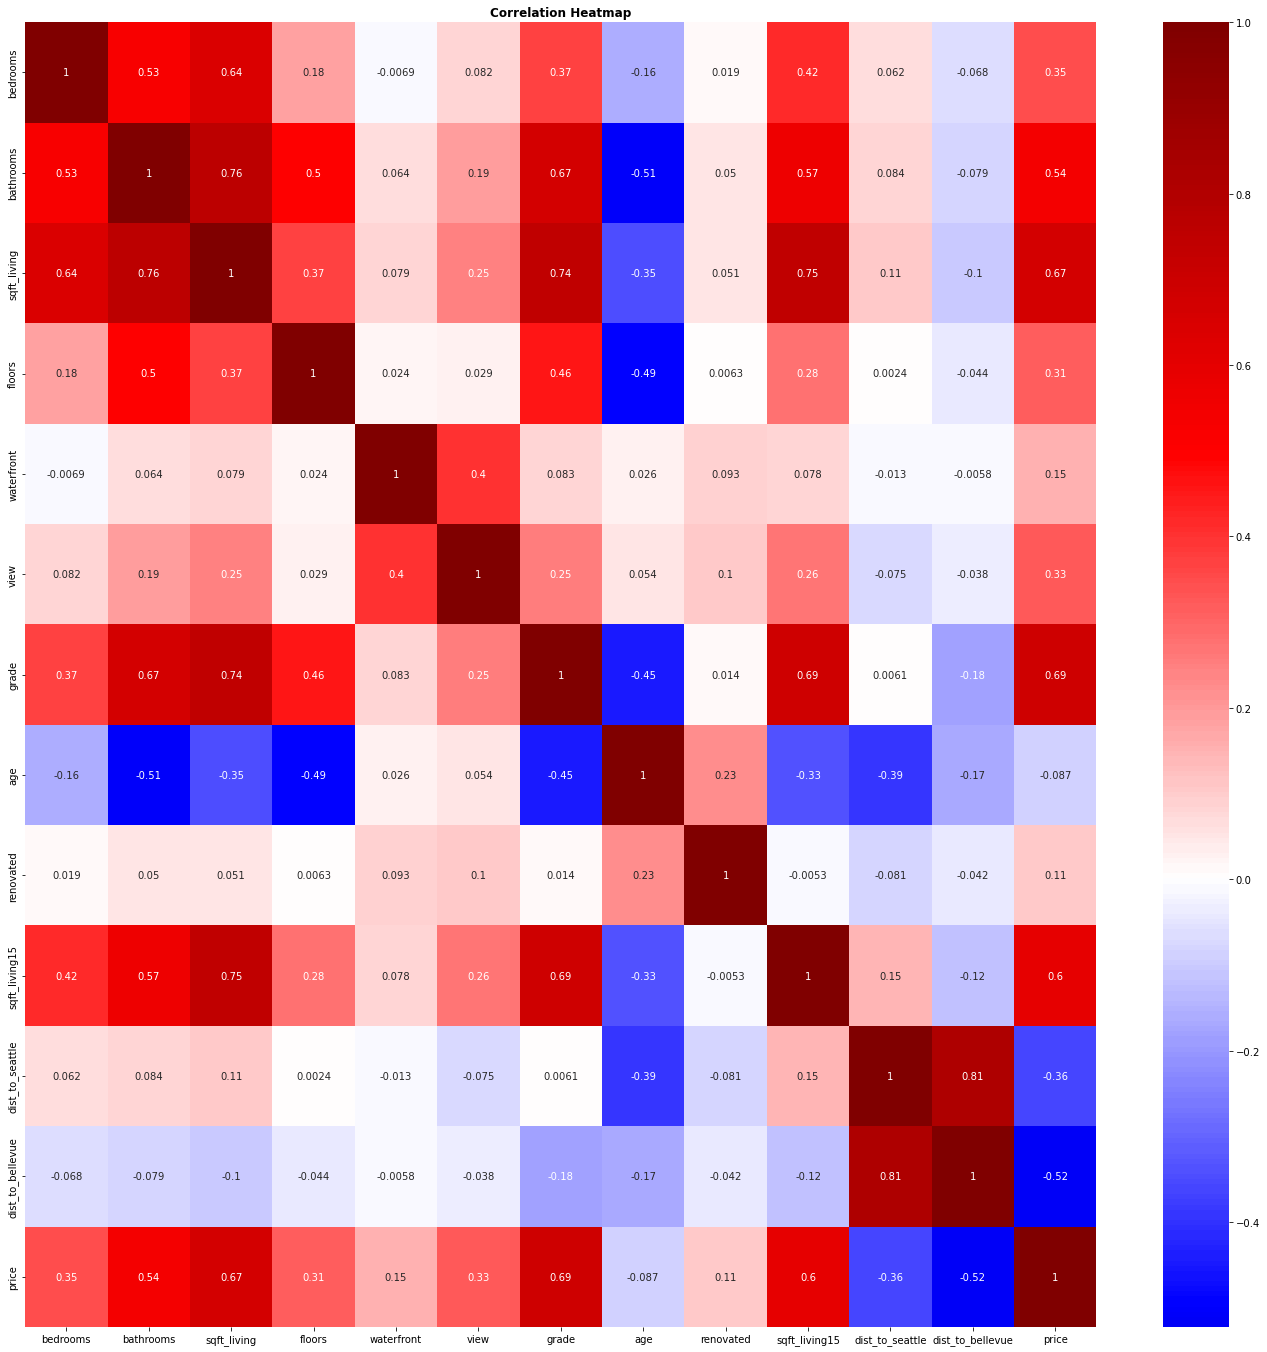

In [78]:
my_correlation_heatmap(hp_df, figsize=(24,24))

# Regression Models

## Model 1 - Simple Linear Regression (sqft_living VS Price)

In [86]:
# Import the data and define our dataframe

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
[["sqft_living", "price"]]
.reset_index(drop = True)
)


In [87]:
# Normalization

# hp_df["price"] = var_normalization(hp_df["price"])[1]
# hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]

In [88]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler="standard")

In [89]:
X_train = split_scaling_encoding_output["train"][0]
y_train = split_scaling_encoding_output["train"][2]

X_test = split_scaling_encoding_output["test"][0]
y_test = split_scaling_encoding_output["test"][2]

The model performance for the train set
-------------------------------------------
RMSE of train set is 0.7441260569436673
Adjusted R2 score of train set is 0.4499026044753498

The model performance for the test set
-------------------------------------------
RMSE of test set is 0.7369809919748361
Adjusted R2 score of test set is 0.4418071712489503


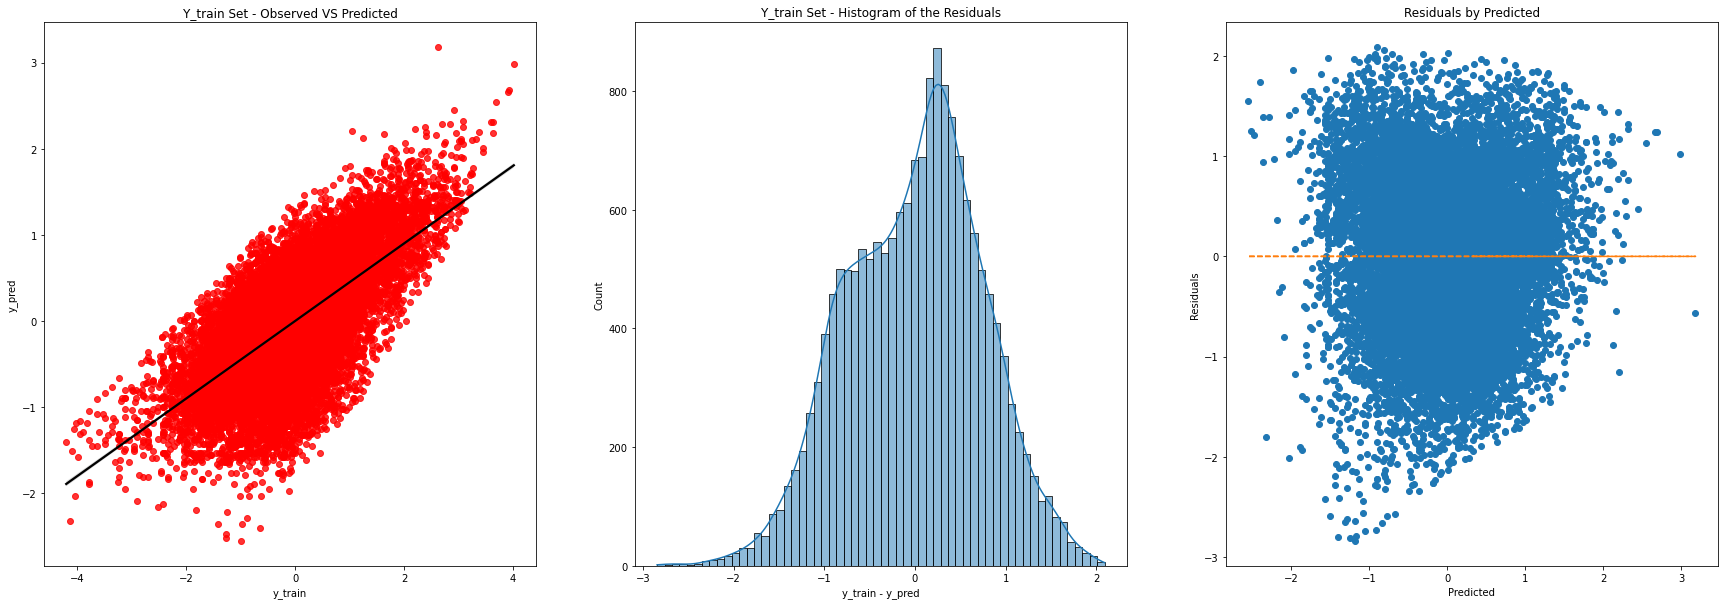

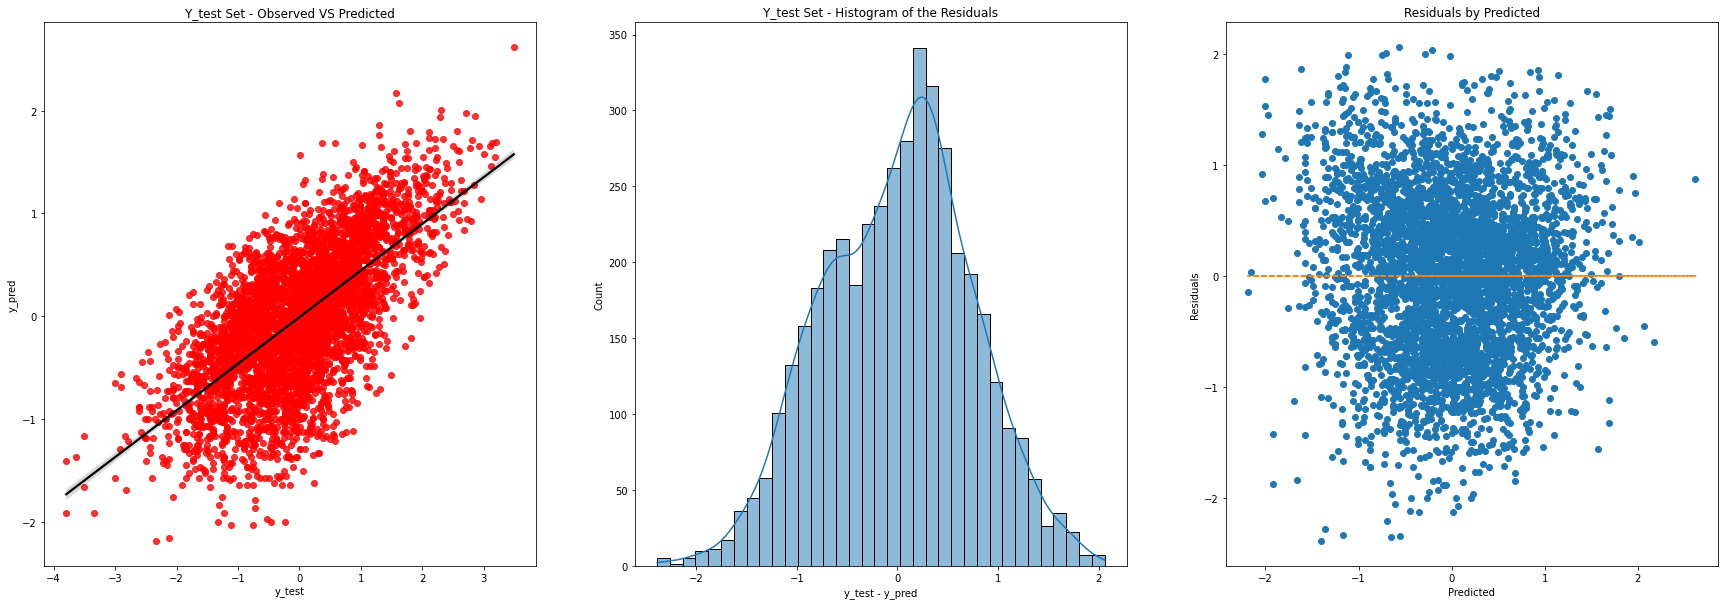

In [92]:
reg_m1_output = my_linear_regression(X_train, y_train, X_test, y_test)

## Model 3 - Multiple Linear Regression (reduced number of variables)

In [416]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition"]
cat_columns = ['waterfront', 'view', 'grade', 'renovated']

In [417]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_age)
.pipe(transform_renovated)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [418]:
# Normalization with Box-cox

hp_df["price"] = var_normalization(hp_df["price"])[1]
hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]
hp_df["sqft_living15"] = var_normalization(hp_df["sqft_living15"])[1]

In [419]:
# Location to Distance_to Transformation

latlong = hp_df[['long', 'lat']]
latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_seattle', latlong['long_lat'].apply(haversine))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_bellevue', latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492]))
hp_df = hp_df.drop(["zipcode"], axis=1)


C:\Users\ehern\AppData\Local\Temp/ipykernel_10012/1688423259.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))


In [420]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler="standard")

In [421]:
X_train = pd.concat([split_scaling_encoding_output["train"][0], split_scaling_encoding_output["train"][1].reset_index(drop=True)], axis=1)
y_train = split_scaling_encoding_output["train"][2]

X_test = pd.concat([split_scaling_encoding_output["test"][0], split_scaling_encoding_output["test"][1].reset_index(drop=True)], axis=1)
y_test = split_scaling_encoding_output["test"][2]

In [422]:
X_train

,bedrooms,bathrooms,sqft_living,floors,age,lat,long,sqft_living15,dist_to_seattle,dist_to_bellevue,waterfront,view,grade,renovated
0,0.692179,0.49184,0.870075,0.926436,-1.017420,-0.573493,0.178190,1.067616,-0.054263,-0.269736,0,0,7,0
1,-0.414027,0.81582,1.020563,0.926436,-0.881649,0.193592,1.708209,1.492334,0.807322,-0.109376,0,0,10,0
2,-0.414027,0.16786,-0.659226,0.926436,-1.085306,-0.188870,1.006950,-0.882081,0.266439,-0.528615,0,0,7,0
3,-0.414027,-0.48010,-0.129476,-0.921516,-0.304621,-1.081282,1.814460,-0.375051,1.605235,1.210829,0,0,7,0
4,-1.520233,0.49184,-0.305084,2.774387,-1.288963,0.511231,-1.040159,-0.318098,-1.431184,-0.487900,0,0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17271,-1.520233,-0.48010,-0.998811,-0.921516,-0.508278,0.954916,0.199440,-0.318098,-0.366569,-0.967427,0,0,7,0
17272,-0.414027,0.16786,-1.524054,0.926436,-1.221077,0.988768,-1.082659,-2.063853,-0.781713,-0.148616,0,0,7,0
17273,-0.414027,-0.48010,-0.634993,0.926436,0.034807,-1.656056,-1.139327,0.175039,1.152744,1.858193,1,4,8,0
17274,-0.414027,-1.45204,-1.255327,-0.921516,1.120978,1.183961,-0.537236,-0.067949,-0.485359,-0.350227,0,0,7,0


The model performance for the train set
-------------------------------------------
RMSE of train set is 0.46130415162097355
Adjusted R2 score of train set is 0.7868229607037228

The model performance for the test set
-------------------------------------------
RMSE of test set is 0.46142233910276315
Adjusted R2 score of test set is 0.7870152524595897


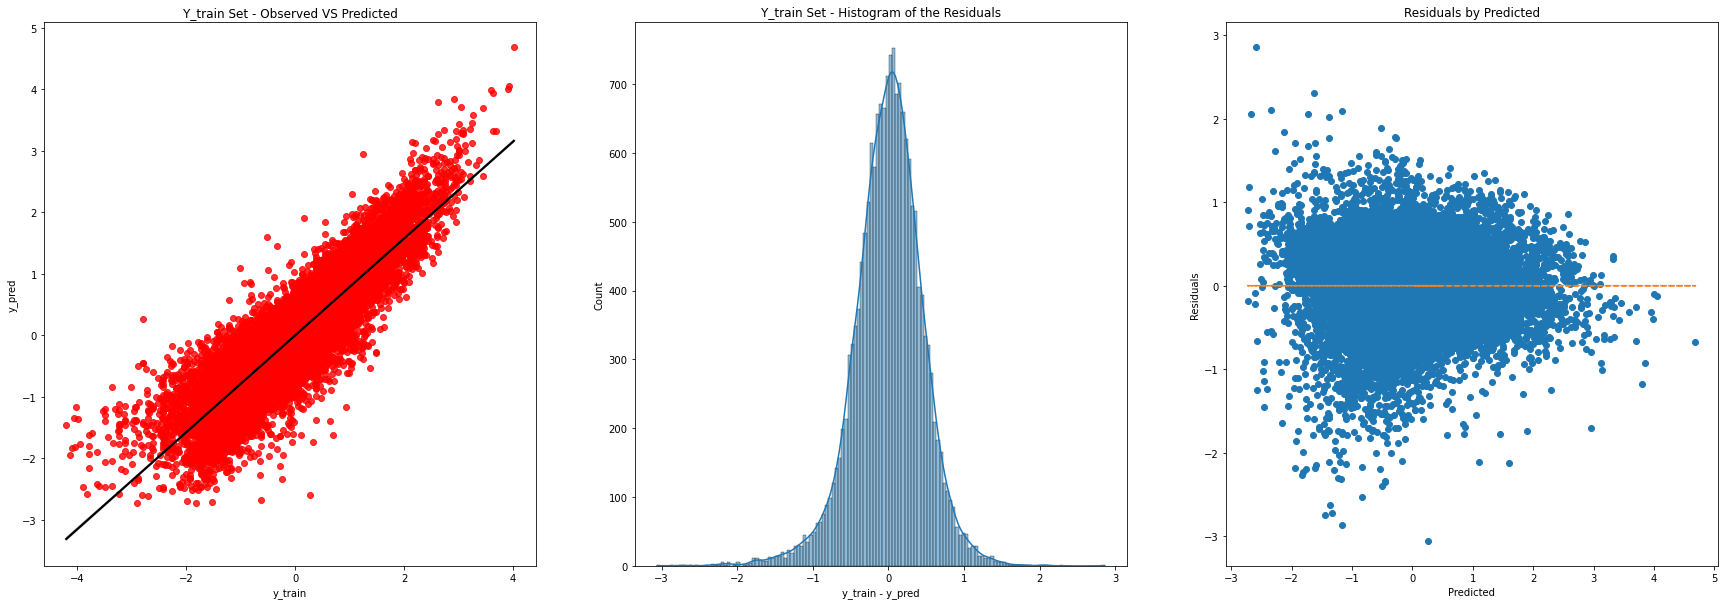

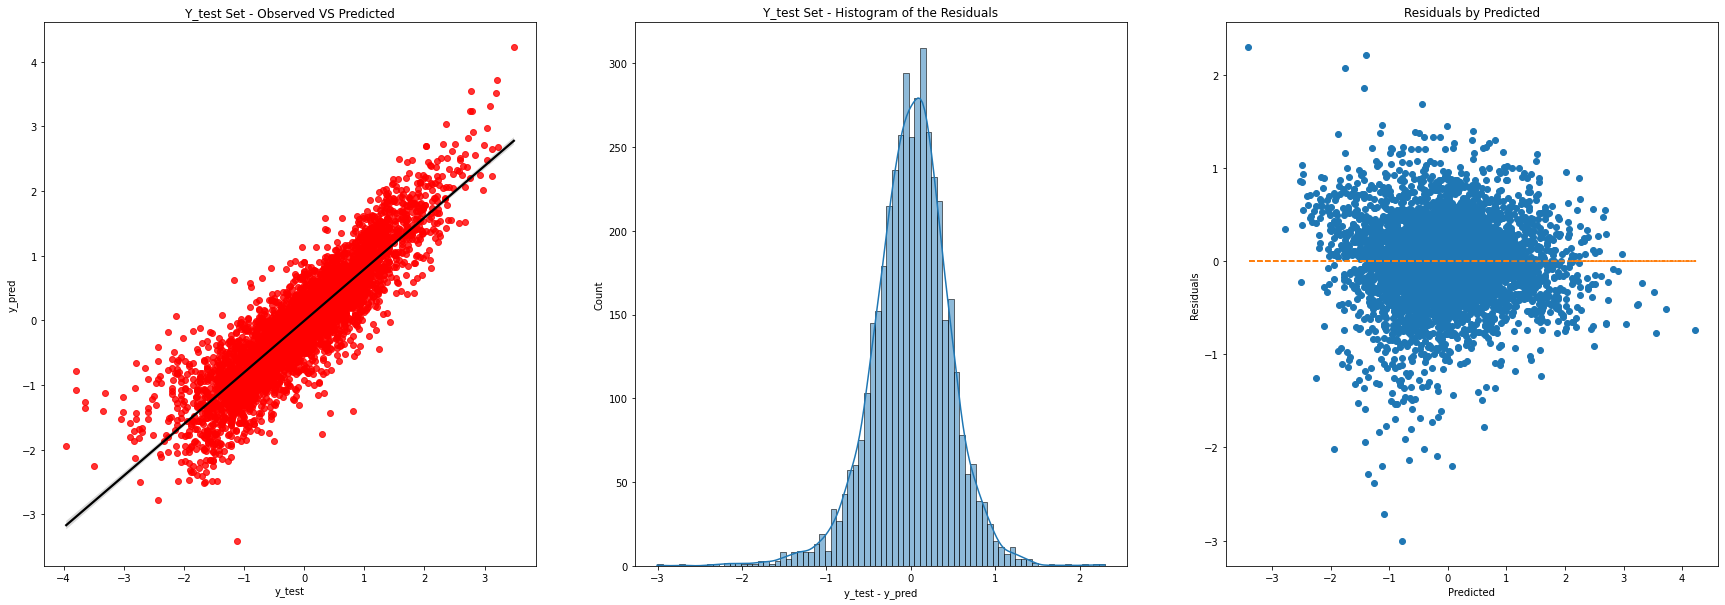

In [423]:
reg_m3_output = my_flex_regression(X_train, y_train, X_test, y_test, model=LinearRegression())

## Model 4 - Ridge Regression

In [353]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition"]
cat_columns = ['waterfront', 'view', 'grade', 'renovated']

In [354]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_age)
.pipe(transform_renovated)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [355]:
# Normalization

hp_df["price"] = var_normalization(hp_df["price"])[1]
hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]
hp_df["sqft_living15"] = var_normalization(hp_df["sqft_living15"])[1]

In [356]:
# Location to Distance_to Transformation

latlong = hp_df[['long', 'lat']]
latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_seattle', latlong['long_lat'].apply(haversine))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_bellevue', latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492]))



C:\Users\ehern\AppData\Local\Temp/ipykernel_10012/3174363302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))


In [357]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler="standard")

In [358]:
X_train = pd.concat([split_scaling_encoding_output["train"][0], split_scaling_encoding_output["train"][1].reset_index(drop=True)], axis=1)
y_train = split_scaling_encoding_output["train"][2]

X_test = pd.concat([split_scaling_encoding_output["test"][0], split_scaling_encoding_output["test"][1].reset_index(drop=True)], axis=1)
y_test = split_scaling_encoding_output["test"][2]

The model performance for the train set
-------------------------------------------
RMSE of train set is 0.4517959275934268
Adjusted R2 score of train set is 0.7955083943568348

The model performance for the test set
-------------------------------------------
RMSE of test set is 0.4501573613108359
Adjusted R2 score of test set is 0.7972406563973029


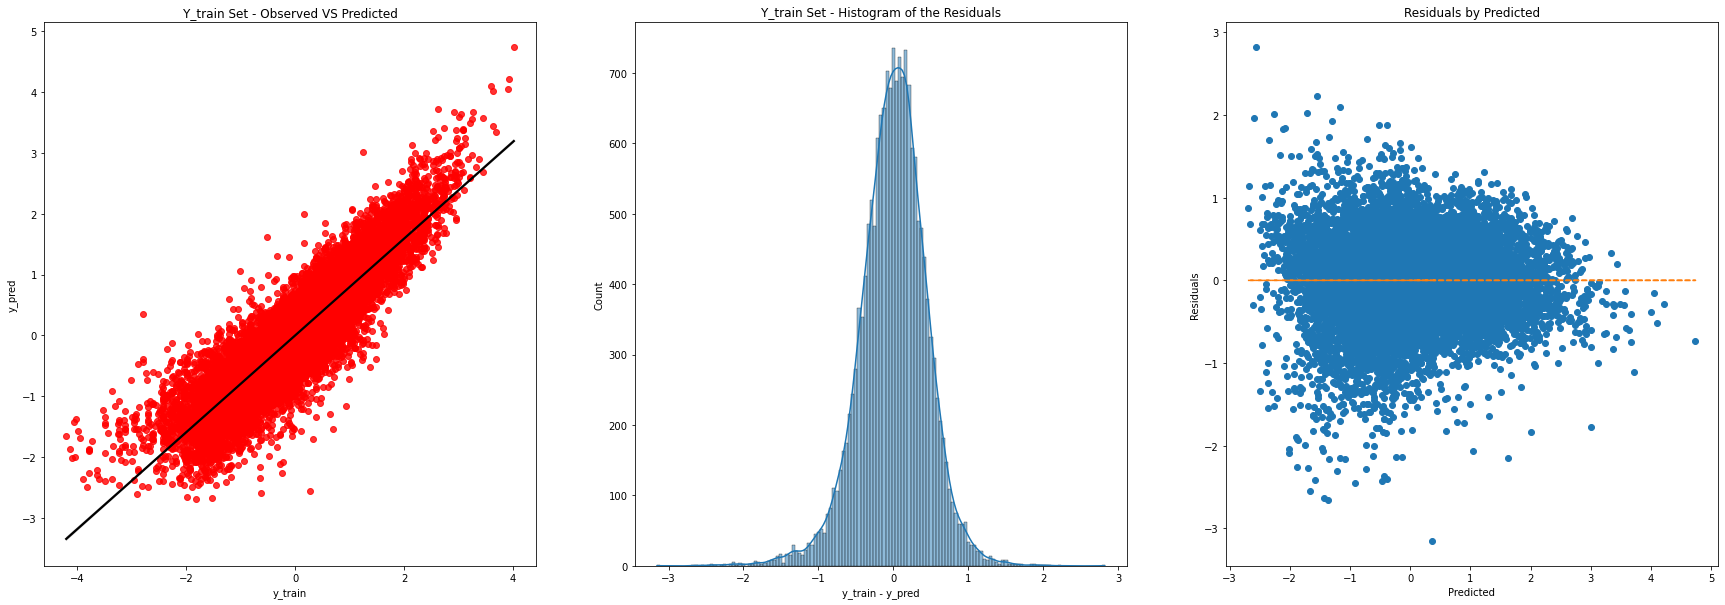

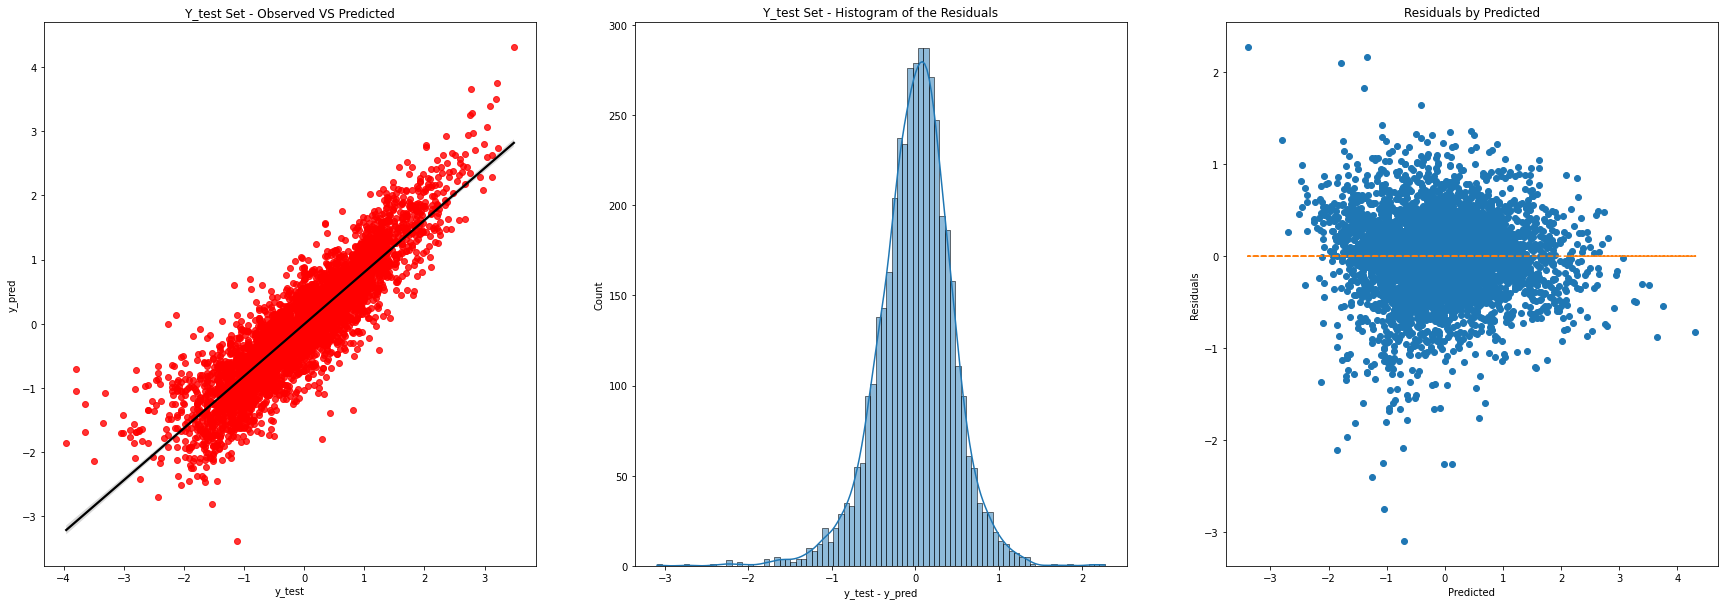

In [359]:
reg_m4_output = my_flex_regression(X_train, y_train, X_test, y_test, model = Ridge(), alpha = 1)

## Model 5 - Lasso Regression

In [360]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition"]
cat_columns = ['waterfront', 'view', 'grade', 'renovated']

In [361]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_age)
.pipe(transform_renovated)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [362]:
# Normalization

hp_df["price"] = var_normalization(hp_df["price"])[1]
hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]
hp_df["sqft_living15"] = var_normalization(hp_df["sqft_living15"])[1]

In [363]:
# Location to Distance_to Transformation

latlong = hp_df[['long', 'lat']]
latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_seattle', latlong['long_lat'].apply(haversine))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_bellevue', latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492]))



C:\Users\ehern\AppData\Local\Temp/ipykernel_10012/3174363302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))


In [364]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler="standard")

In [365]:
X_train = pd.concat([split_scaling_encoding_output["train"][0], split_scaling_encoding_output["train"][1].reset_index(drop=True)], axis=1)
y_train = split_scaling_encoding_output["train"][2]

X_test = pd.concat([split_scaling_encoding_output["test"][0], split_scaling_encoding_output["test"][1].reset_index(drop=True)], axis=1)
y_test = split_scaling_encoding_output["test"][2]

The model performance for the train set
-------------------------------------------
RMSE of train set is 0.4521762797255688
Adjusted R2 score of train set is 0.7951639399110391

The model performance for the test set
-------------------------------------------
RMSE of test set is 0.45065529157263096
Adjusted R2 score of test set is 0.7967918540054505


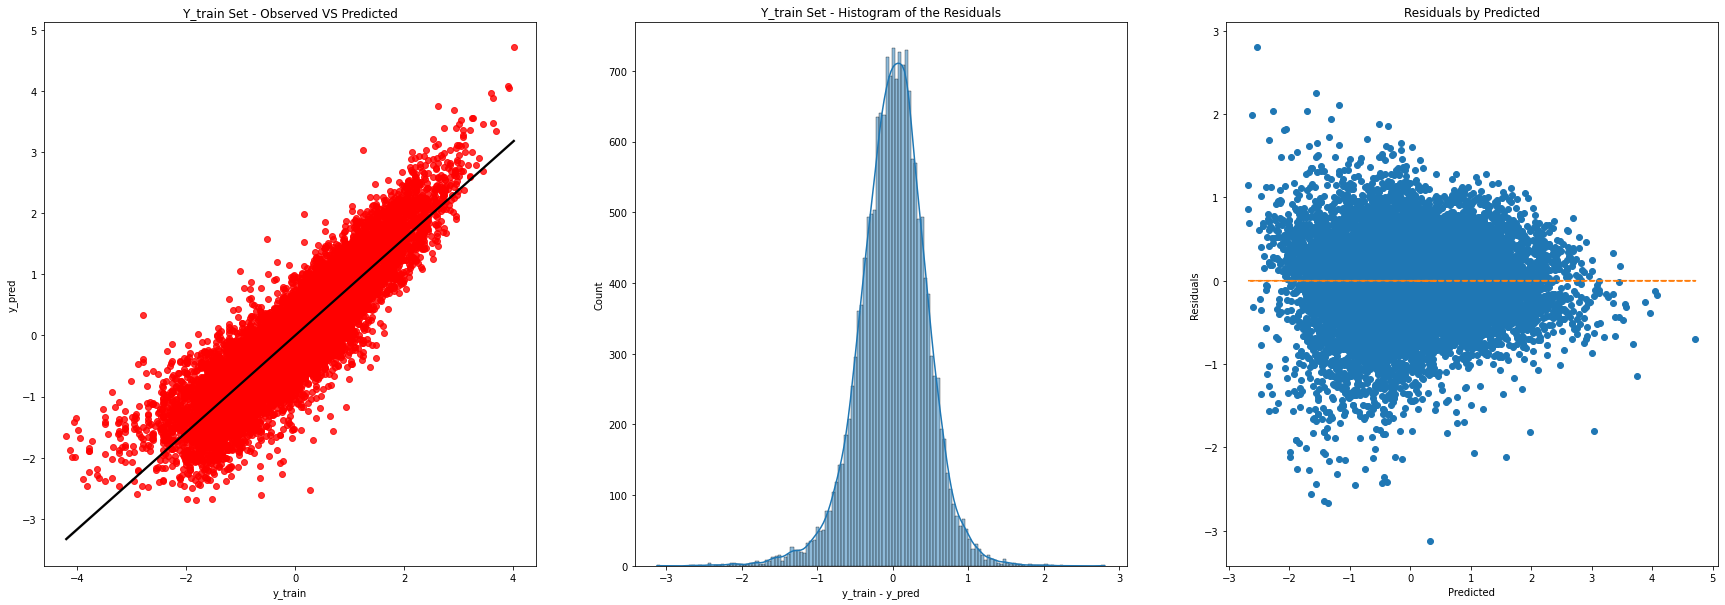

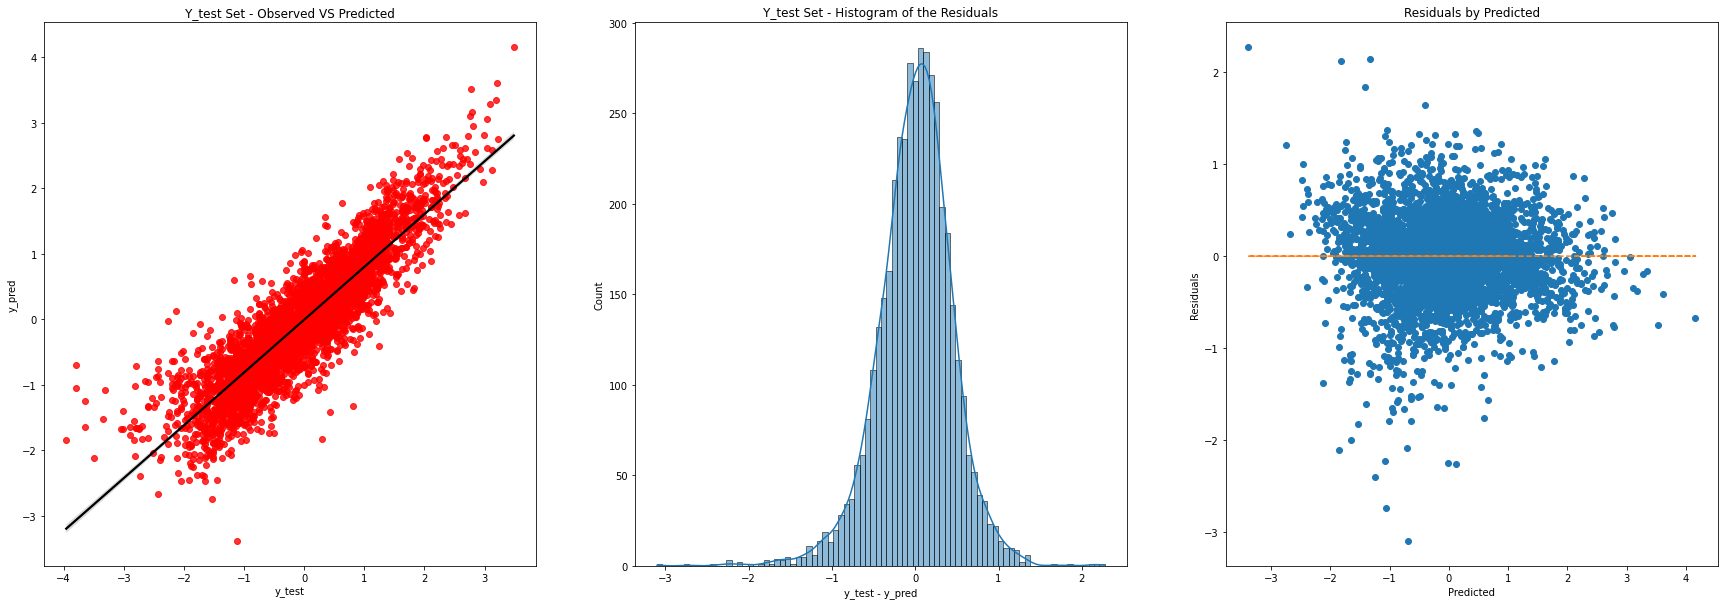

In [367]:
reg_m5_output = my_flex_regression(X_train, y_train, X_test, y_test, model = Lasso(), alpha = 0.001)

## Model 6 - Polynomial Regression

In [368]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition"]
cat_columns = ['waterfront', 'view', 'grade', 'renovated']

In [369]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_age)
.pipe(transform_renovated)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [370]:
# Normalization

hp_df["price"] = var_normalization(hp_df["price"])[1]
hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]
hp_df["sqft_living15"] = var_normalization(hp_df["sqft_living15"])[1]

In [371]:
# Location to Distance_to Transformation

latlong = hp_df[['long', 'lat']]
latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_seattle', latlong['long_lat'].apply(haversine))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_bellevue', latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492]))



C:\Users\ehern\AppData\Local\Temp/ipykernel_10012/3174363302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))


In [372]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler="standard")

In [373]:
X_train = pd.concat([split_scaling_encoding_output["train"][0], split_scaling_encoding_output["train"][1].reset_index(drop=True)], axis=1)
y_train = split_scaling_encoding_output["train"][2]

X_test = pd.concat([split_scaling_encoding_output["test"][0], split_scaling_encoding_output["test"][1].reset_index(drop=True)], axis=1)
y_test = split_scaling_encoding_output["test"][2]

In [374]:
# Polynomial Transformation - order n

n = 2
polynomial_features= PolynomialFeatures(degree=n)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.transform(X_test)


The model performance for the train set
-------------------------------------------
RMSE of train set is 0.3750855699609293
Adjusted R2 score of train set is 0.8580593182489622

The model performance for the test set
-------------------------------------------
RMSE of test set is 0.37705717994487115
Adjusted R2 score of test set is 0.8536303643011351


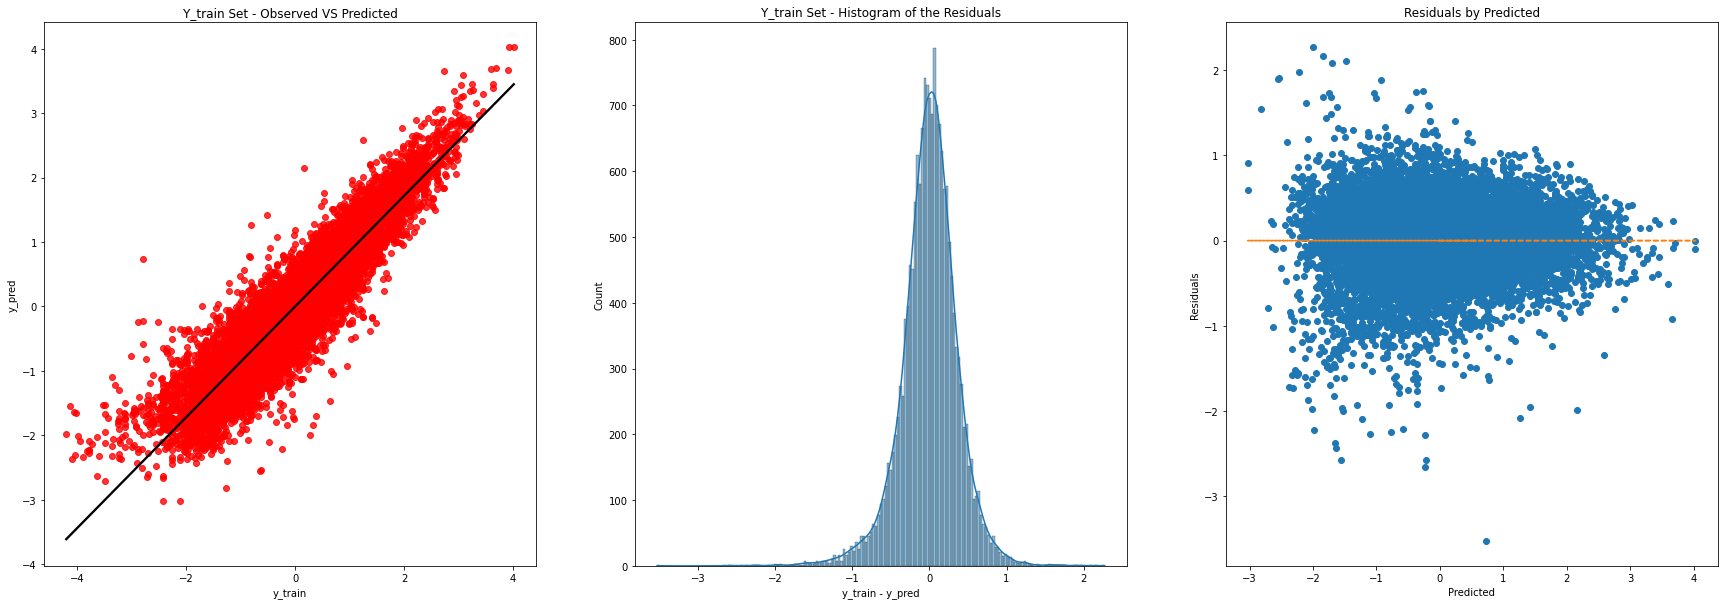

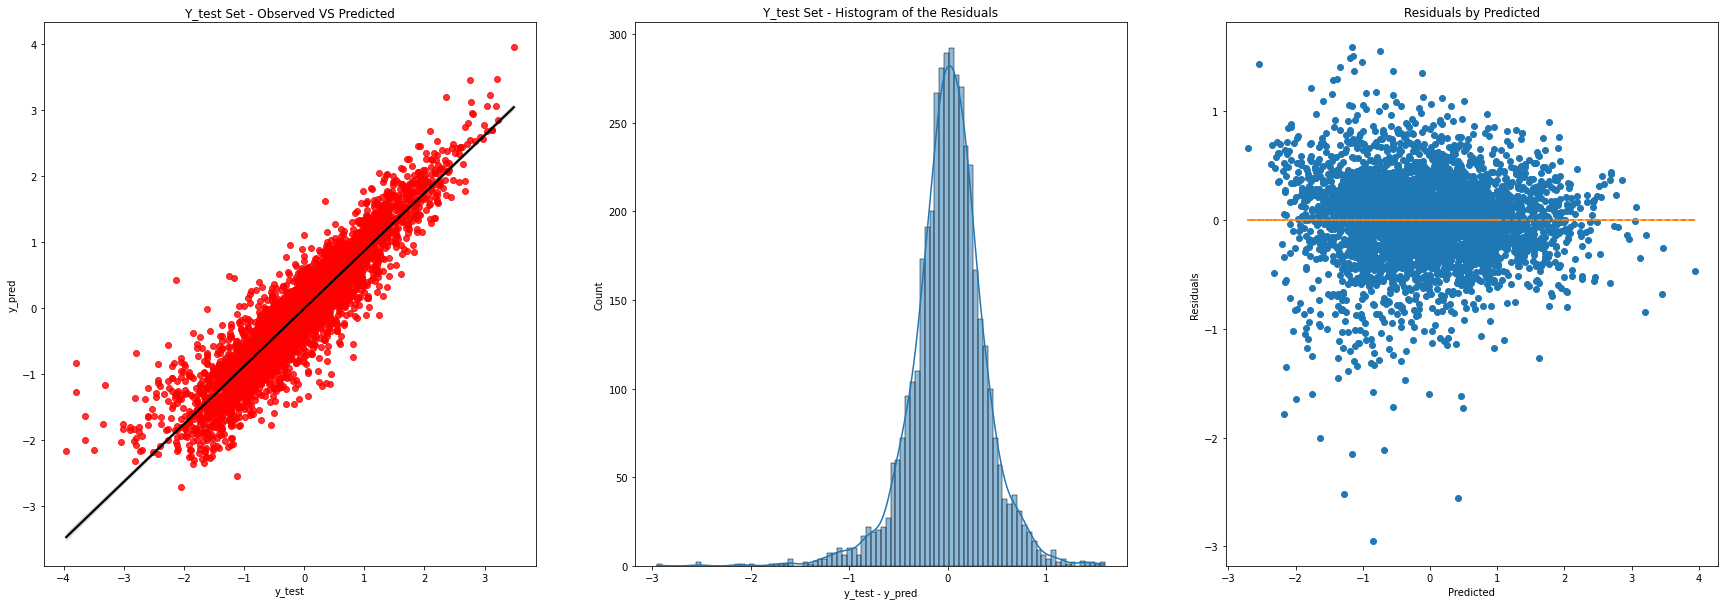

In [375]:
reg_m6_output = my_flex_regression(X_train_poly, y_train, X_test_poly, y_test, model = LinearRegression())

In [ ]:
pd.DataFrame(x_poly)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,1.0,0.692179,0.49184,0.871136,0.926436,-0.089406,-0.306906,-0.566855,-1.017420,-0.212884,...,0.04532,-0.227352,0.011552,0.057423,1.140536,-0.057950,-0.288067,0.002944,0.014637,0.072757
1,1.0,-0.414027,0.81582,1.020280,0.926436,-0.089406,-0.306906,1.995860,-0.881649,-0.212884,...,0.04532,-0.326738,-0.171866,0.023284,2.355649,1.239088,-0.167872,0.651769,-0.088302,0.011963
2,1.0,-0.414027,0.16786,-0.656497,0.926436,-0.089406,-0.306906,-0.566855,-1.085306,-0.212884,...,0.04532,0.188637,-0.056721,0.112534,0.785177,-0.236092,0.468407,0.070990,-0.140843,0.279434
3,1.0,-0.414027,-0.48010,-0.124835,-0.921516,-0.089406,-0.306906,-0.566855,-0.304621,-0.212884,...,0.04532,0.086228,-0.341729,-0.257767,0.164061,-0.650191,-0.490439,2.576779,1.943665,1.466107
4,1.0,-1.520233,0.49184,-0.300782,2.774387,-0.089406,-0.306906,1.141622,-1.288963,-0.212884,...,0.04532,0.074488,0.304677,0.103866,0.122429,0.500770,0.170716,2.048287,0.698274,0.238046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17271,1.0,-1.520233,-0.48010,-0.998712,-0.921516,-0.089406,-0.306906,-0.566855,-0.508278,-0.212884,...,0.04532,0.074488,0.078037,0.205950,0.122429,0.128262,0.338502,0.134373,0.354628,0.935915
17272,1.0,-0.414027,0.16786,-1.530203,0.926436,-0.089406,-0.306906,-0.566855,-1.221077,-0.212884,...,0.04532,0.413798,0.166415,0.031638,3.778230,1.519468,0.288875,0.611075,0.116175,0.022087
17273,1.0,-0.414027,-0.48010,-0.632118,0.926436,11.184909,4.854558,0.287383,0.034807,-0.212884,...,0.04532,-0.029260,-0.245401,-0.395580,0.018891,0.158440,0.255400,1.328818,2.142020,3.452880
17274,1.0,-0.414027,-1.45204,-1.257947,-0.921516,-0.089406,-0.306906,-0.566855,1.120978,-0.212884,...,0.04532,0.022339,0.103325,0.074558,0.011011,0.050930,0.036750,0.235573,0.169986,0.122659


In [ ]:
model = LinearRegression()
model.fit(x_poly, y_train)

LinearRegression()

In [ ]:
y_poly_pred = model.predict(x_test_poly)

In [ ]:
y_poly_pred

array([1.16368866, 0.88503265, 0.03414917, ..., 0.38864899, 1.61611938,
       1.74202728])

In [ ]:
R2 = r2_score(y_test, y_poly_pred)

In [ ]:
R2

0.8110621225346798

## Model 7 - XGBoost

In [ ]:
xgb = xgboost.XGBRegressor(n_estimators=800, learning_rate=0.05,reg_alpha= 0.1, subsample=0.95,colsample_bytree=1, max_depth=6)


In [ ]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
R2 = r2_score(y_test, y_pred)
R2

0.8472013083447533

0.8349280504471069

# To be deleted

In [ ]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition"]
cat_columns = ['waterfront', 'view', 'grade', 'renovated']

In [ ]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_age)
.pipe(transform_renovated)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [ ]:
# Normalization

hp_df["price"] = var_normalization(hp_df["price"])[1]
hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]
hp_df["sqft_living15"] = var_normalization(hp_df["sqft_living15"])[1]

In [ ]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler="standard")

In [ ]:
X_train = pd.concat([split_scaling_encoding_output["train"][0], split_scaling_encoding_output["train"][1].reset_index(drop=True)], axis=1)
y_train = split_scaling_encoding_output["train"][2]

X_test = pd.concat([split_scaling_encoding_output["test"][0], split_scaling_encoding_output["test"][1].reset_index(drop=True)], axis=1)
y_test = split_scaling_encoding_output["test"][2]

In [ ]:
n = 4
polynomial_features= PolynomialFeatures(degree=n)

In [ ]:
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.transform(X_test)

In [ ]:
model = LinearRegression()
model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)

In [ ]:
r2_score(y_test, y_pred)

0.7222789465402334